# Parte 2 - Modelagem de Clusterização de Clientes

## Objetivo
Este notebook implementa uma solução de clusterização para segmentar os clientes com base em seus perfis de consumo e engajamento com ofertas. A partir dessa segmentação, identificaremos oportunidades para aumentar a taxa de conversão e, consequentemente, a receita.

## Metodologia
1. Análise exploratória e preparação dos dados
2. Redução de dimensionalidade com PCA (Principal Component Analysis)
3. Clusterização com K-means
4. Análise de perfis dos clusters
5. Estratégias para aumento de conversão e receita

In [0]:
# Importação de bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualizações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
%matplotlib inline

# 1.0  Carregamento e Análise Exploratória dos Dados

In [0]:
df = spark.table('workspace.default.dataset_features').toPandas()

df.head()

,account_id,age,gender,gmv_total,days_since_registration,max_credit_card_limit,tot_subsidio_utilizado,qt_offer_completed,qt_offer_received,qt_offer_viewed,qt_transaction,channels_frequency_conversao,channel_web_frequency_conversao,channel_email_frequency_conversao,channel_mobile_frequency_conversao,channel_social_frequency_conversao,bogo_conversao,discount_conversao,informational_conversao,avg_discount_value_conversao,avg_duration_conversao,avg_min_value_conversao,reward_conversao,amount_conversao,qt_transacional_conversao,min_time_conversao,max_time_conversao
0,03833a1fe27f4435917da7e54c6fa48a,118,None,2.38,2848.0,NaN,NaN,NaN,4.0,4.0,2.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dd69125d21a54693840469a1ad6ca243,66,M,15.99,3005.0,32000.0,3.0,1.0,3.0,3.0,6.0,"[{'channel': 'web', 'frequency': 1}, {'channel...",1.0,1.0,1.0,1.0,0.0,1.0,0.0,3.000000,7.0,7.0,3.0,4.20,1.0,4.00,4.00
2,3d55f046a320408db9a88be59acc19cc,118,None,24.46,3431.0,NaN,2.0,1.0,6.0,4.0,12.0,"[{'channel': 'web', 'frequency': 1}, {'channel...",1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.000000,10.0,10.0,2.0,2.59,1.0,25.00,25.00
3,752045b74388467d99a44eac9501116e,43,F,14.23,3044.0,42000.0,NaN,NaN,5.0,2.0,5.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b66cb315b9944a749e25aee0d7dfe13c,87,M,84.95,2902.0,33000.0,7.0,3.0,6.0,5.0,9.0,"[{'channel': 'web', 'frequency': 3}, {'channel...",3.0,3.0,3.0,2.0,0.0,3.0,0.0,2.333333,8.0,9.0,7.0,24.36,3.0,17.25,28.75


In [0]:
# Análise da estrutura dos dados
print("Informações do dataset:")
print(df.info())
print("\n")
print("Estatísticas descritivas:")
df.describe()

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   account_id                          17000 non-null  object 
 1   age                                 17000 non-null  int64  
 2   gender                              14825 non-null  object 
 3   gmv_total                           16578 non-null  float64
 4   days_since_registration             17000 non-null  float64
 5   max_credit_card_limit               14825 non-null  float64
 6   tot_subsidio_utilizado              12774 non-null  float64
 7   qt_offer_completed                  12774 non-null  float64
 8   qt_offer_received                   16994 non-null  float64
 9   qt_offer_viewed                     16834 non-null  float64
 10  qt_transaction                      16578 non-null  float64
 11  channels_frequenc

,age,gmv_total,days_since_registration,max_credit_card_limit,tot_subsidio_utilizado,qt_offer_completed,qt_offer_received,qt_offer_viewed,qt_transaction,channel_web_frequency_conversao,channel_email_frequency_conversao,channel_mobile_frequency_conversao,channel_social_frequency_conversao,bogo_conversao,discount_conversao,informational_conversao,avg_discount_value_conversao,avg_duration_conversao,avg_min_value_conversao,reward_conversao,amount_conversao,qt_transacional_conversao,min_time_conversao,max_time_conversao
count,17000.000000,16578.000000,17000.000000,14825.000000,12774.000000,12774.000000,16994.000000,16834.000000,16578.000000,12774.000000,12774.000000,12774.000000,12774.000000,12774.000000,12774.000000,12774.0,12774.000000,12774.000000,12774.000000,12774.000000,12774.000000,12774.000000,12774.00000,12774.000000
mean,62.531412,107.096874,3240.449882,65404.991568,12.891498,2.628699,4.488467,3.429072,8.381771,2.339987,2.628699,2.360968,1.705652,1.226632,1.402067,0.0,4.753841,7.340417,9.077349,12.891498,48.271777,2.628699,10.94798,21.861574
std,26.738580,126.393939,411.223904,21598.299410,8.508112,1.308750,1.073047,1.259239,5.009822,1.239769,1.308750,1.232299,1.122472,1.050621,1.045919,0.0,1.995253,1.260902,2.793640,8.508112,69.479639,1.308750,8.16828,5.918863
min,18.000000,0.050000,2723.000000,30000.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,5.000000,5.000000,2.000000,0.230000,1.000000,0.00000,0.000000
25%,45.000000,23.682500,2931.000000,49000.000000,5.000000,2.000000,4.000000,3.000000,5.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.0,3.200000,6.666667,7.333333,5.000000,14.712500,2.000000,3.25000,19.250000
50%,58.000000,72.410000,3081.000000,64000.000000,12.000000,3.000000,5.000000,3.000000,7.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,0.0,4.750000,7.000000,8.750000,12.000000,37.235000,3.000000,9.25000,24.000000
75%,73.000000,150.937500,3514.000000,80000.000000,18.000000,4.000000,5.000000,4.000000,11.000000,3.000000,4.000000,3.000000,2.000000,2.000000,2.000000,0.0,6.000000,8.000000,10.000000,18.000000,63.017500,4.000000,17.50000,25.750000
max,118.000000,1608.690000,4546.000000,120000.000000,55.000000,6.000000,6.000000,6.000000,36.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.0,10.000000,10.000000,20.000000,55.000000,1268.390000,6.000000,29.75000,29.750000


In [0]:
# Análise de valores ausentes
# É importante identificar padrões de missing data que podem indicar segmentos específicos
missing_analysis = pd.DataFrame({
    'missing_count': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('missing_count', ascending=False)

print("Análise de valores ausentes:")
print(missing_analysis[missing_analysis['missing_count'] > 0])

Análise de valores ausentes:
                                    missing_count  missing_pct
channel_email_frequency_conversao            4226        24.86
channel_mobile_frequency_conversao           4226        24.86
min_time_conversao                           4226        24.86
qt_transacional_conversao                    4226        24.86
amount_conversao                             4226        24.86
reward_conversao                             4226        24.86
avg_min_value_conversao                      4226        24.86
avg_duration_conversao                       4226        24.86
avg_discount_value_conversao                 4226        24.86
informational_conversao                      4226        24.86
discount_conversao                           4226        24.86
bogo_conversao                               4226        24.86
channel_social_frequency_conversao           4226        24.86
max_time_conversao                           4226        24.86
channel_web_frequency_conv

# 2.0 Preparação dos Dados para Modelagem

Para a clusterização, precisamos:
1. Selecionar features relevantes para segmentação
2. Tratar valores ausentes de forma apropriada
3. Normalizar as features para que tenham a mesma escala

In [0]:
# Criação de uma cópia do dataframe para preservar os dados originais
df_model = df.copy()

# Seleção de features para modelagem
# Foi incluído features que capturam diferentes aspectos do comportamento do cliente:
# - Demográficas: age, days_since_registration, max_credit_card_limit
# - Transacionais: gmv_total, qt_transaction
# - Engajamento com ofertas: qt_offer_received, qt_offer_viewed, qt_offer_completed
# - Conversão: qt_offer_completed / qt_offer_received (taxa de conversão)

features_clustering = [
    'age',
    'gmv_total',
    'days_since_registration',
    'max_credit_card_limit',
    'tot_subsidio_utilizado',
    'qt_offer_completed',
    'qt_offer_received',
    'qt_offer_viewed',
    'qt_transaction',
    'bogo_conversao',
    'discount_conversao',
    'informational_conversao',
    'reward_conversao',
    'amount_conversao'
]

# Criação de features derivadas que podem ser úteis para segmentação
# Taxa de conversão: proporção de ofertas completadas em relação às recebidas
df_model['conversao_rate'] = np.where(
    df_model['qt_offer_received'] > 0,
    df_model['qt_offer_completed'] / df_model['qt_offer_received'],
    0
)

# Taxa de visualização: proporção de ofertas visualizadas em relação às recebidas
df_model['view_rate'] = np.where(
    df_model['qt_offer_received'] > 0,
    df_model['qt_offer_viewed'] / df_model['qt_offer_received'],
    0
)

# Ticket médio: GMV total dividido pelo número de transações
df_model['avg_ticket'] = np.where(
    df_model['qt_transaction'] > 0,
    df_model['gmv_total'] / df_model['qt_transaction'],
    0
)

# Adicionando as novas features à lista
features_clustering.extend(['conversao_rate', 'view_rate', 'avg_ticket'])

print(f"Features selecionadas para clusterização ({len(features_clustering)}): ")
for i, feat in enumerate(features_clustering, 1):
    print(f"{i:2d}. {feat}")

Features selecionadas para clusterização (17): 
 1. age
 2. gmv_total
 3. days_since_registration
 4. max_credit_card_limit
 5. tot_subsidio_utilizado
 6. qt_offer_completed
 7. qt_offer_received
 8. qt_offer_viewed
 9. qt_transaction
10. bogo_conversao
11. discount_conversao
12. informational_conversao
13. reward_conversao
14. amount_conversao
15. conversao_rate
16. view_rate
17. avg_ticket


In [0]:
# Tratamento de valores ausentes
# Estratégia: 
# - Para features numéricas, imputamos com a mediana (mais robusta a outliers)
# - Valores ausentes em features de conversão indicam não engajamento, então imputamos com 0

df_features = df_model[features_clustering].copy()

# Imputação específica para cada grupo de features
demographic_features = ['age', 'days_since_registration', 'max_credit_card_limit']
engagement_features = ['qt_offer_completed', 'qt_offer_received', 'qt_offer_viewed']
conversao_features = ['bogo_conversao', 'discount_conversao', 'informational_conversao',
                       'reward_conversao', 'amount_conversao', 'conversao_rate', 'view_rate']

# Features demográficas: imputar com mediana
for col in demographic_features:
    if col in df_features.columns:
        df_features[col].fillna(df_features[col].median(), inplace=True)

# Features de engajamento e conversão: imputar com 0 (indica não participação)
for col in engagement_features + conversao_features:
    if col in df_features.columns:
        df_features[col].fillna(0, inplace=True)

# Outras features numéricas: imputar com mediana
remaining_cols = [col for col in df_features.columns 
                  if col not in demographic_features + engagement_features + conversao_features]
for col in remaining_cols:
    df_features[col].fillna(df_features[col].median(), inplace=True)

print("Valores ausentes após tratamento:")
print(df_features.isnull().sum().sum())
print("\nEstatísticas após imputação:")
df_features.describe()

Valores ausentes após tratamento:
0

Estatísticas após imputação:


,age,gmv_total,days_since_registration,max_credit_card_limit,tot_subsidio_utilizado,qt_offer_completed,qt_offer_received,qt_offer_viewed,qt_transaction,bogo_conversao,discount_conversao,informational_conversao,reward_conversao,amount_conversao,conversao_rate,view_rate,avg_ticket
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.0,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,62.531412,106.235823,3240.449882,65225.235294,12.669882,1.975235,4.486882,3.395588,8.347471,0.921706,1.053529,0.0,9.686824,36.271981,0.439797,0.760115,13.340673
std,26.738580,124.931843,411.223904,20174.747749,7.385160,1.605563,1.076165,1.297653,4.951916,1.053786,1.090507,0.0,9.243217,63.738464,0.339436,0.236175,15.998435
min,18.000000,0.050000,2723.000000,30000.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,24.420000,2931.000000,51000.000000,7.000000,1.000000,4.000000,2.750000,5.000000,0.000000,0.000000,0.0,2.000000,0.757500,0.166667,0.600000,3.040000
50%,58.000000,72.410000,3081.000000,64000.000000,12.000000,2.000000,5.000000,3.000000,7.000000,1.000000,1.000000,0.0,7.000000,21.755000,0.500000,0.800000,11.413523
75%,73.000000,148.782500,3514.000000,76000.000000,15.000000,3.000000,5.000000,4.000000,11.000000,2.000000,2.000000,0.0,15.000000,53.585000,0.750000,1.000000,20.242654
max,118.000000,1608.690000,4546.000000,120000.000000,55.000000,6.000000,6.000000,6.000000,36.000000,6.000000,6.000000,0.0,55.000000,1268.390000,1.000000,1.000000,451.470000


## 2.3 Padronização das features (StandardScaler)

A padronização transforma cada feature para ter média 0 e desvio padrão 1, conforme a fórmula:

$$
x_{scaled} = \frac{x - \mu}{\sigma}
$$

onde:

- \( x \) é o valor original da feature  
- \(\mu \) é a média da feature
- \( \sigma \) é o desvio padrão da feature


In [0]:
# Normalização das features usando StandardScaler
# StandardScaler transforma as features para ter média 0 e desvio padrão 1
# Isso é fundamental para algoritmos baseados em distância como K-means e PCA

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

# Criando dataframe com features escaladas para facilitar visualização
df_scaled = pd.DataFrame(
    features_scaled,
    columns=df_features.columns,
    index=df_features.index
)

print("Features normalizadas:")
print(f"Shape: {df_scaled.shape}")
print("\nPrimeiras linhas das features normalizadas:")
df_scaled.head()

Features normalizadas:
Shape: (17000, 17)

Primeiras linhas das features normalizadas:


,age,gmv_total,days_since_registration,max_credit_card_limit,tot_subsidio_utilizado,qt_offer_completed,qt_offer_received,qt_offer_viewed,qt_transaction,bogo_conversao,discount_conversao,informational_conversao,reward_conversao,amount_conversao,conversao_rate,view_rate,avg_ticket
0,2.074539,-0.831324,-0.954374,-0.060733,-0.090709,-1.230281,-0.452437,0.465787,-1.281859,-0.874687,-0.966120,0.0,-1.048023,-0.569092,-1.295709,1.015740,-0.759514
1,0.129726,-0.722382,-0.572576,-1.646921,-1.309405,-0.607428,-1.381690,-0.304858,-0.474067,-0.874687,-0.049088,0.0,-0.723452,-0.503196,-0.313658,1.015740,-0.667314
2,2.074539,-0.654583,0.463387,-0.060733,-1.444816,-0.607428,1.406069,0.465787,0.737621,-0.874687,-0.049088,0.0,-0.831642,-0.528456,-0.804684,-0.395684,-0.706486
3,-0.730480,-0.736470,-0.477734,-1.151237,-0.090709,-1.230281,0.476816,-1.075503,-0.676015,-0.874687,-0.966120,0.0,-1.048023,-0.569092,-1.295709,-1.524824,-0.656001
4,0.915131,-0.170384,-0.823055,-1.597352,-0.767763,0.638278,1.406069,1.236432,0.131777,-0.874687,1.784976,0.0,-0.290689,-0.186894,0.177367,0.310028,-0.243893


#3.0 Análise de Componentes Principais (PCA)

PCA é uma técnica de redução de dimensionalidade que transforma as features originais em componentes principais não correlacionados. Isso nos permite:
1. Reduzir a dimensionalidade mantendo a maior parte da variância
2. Visualizar os dados em 2D/3D
3. Remover multicolinearidade
4. Melhorar a performance do K-means

Variância explicada por cada componente:
[3.73825253e-01 1.22789939e-01 1.06232035e-01 8.76081072e-02
 6.91375583e-02 6.34423141e-02 5.76017855e-02 4.19392273e-02
 2.80068278e-02 1.89811981e-02 1.77268791e-02 6.99906162e-03
 2.21171161e-03 2.13044259e-03 1.36766008e-03 4.87703716e-32
 1.08011376e-36]

Variância acumulada por componente:
[0.37382525 0.49661519 0.60284723 0.69045533 0.75959289 0.82303521
 0.88063699 0.92257622 0.95058305 0.96956425 0.98729112 0.99429019
 0.9965019  0.99863234 1.         1.         1.        ]


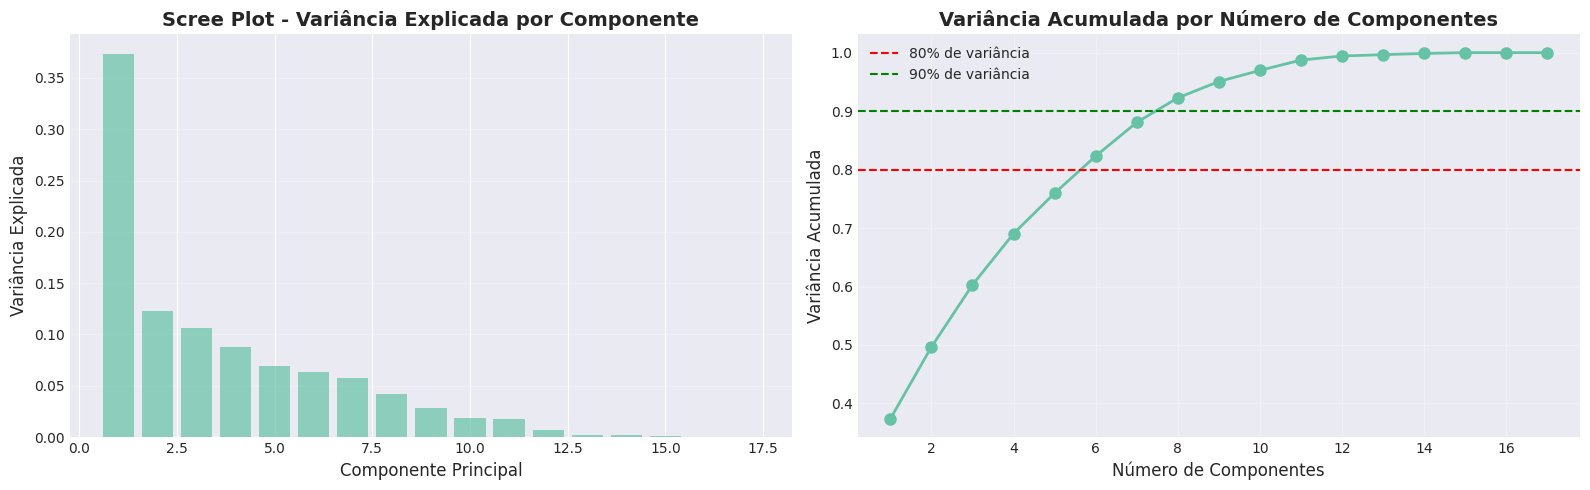

Número de componentes para capturar 80% da variância: 6
Número de componentes para capturar 90% da variância: 8

Os primeiros 5 componentes explicam 75.96% da variância total


In [0]:
# Aplicação do PCA para análise inicial da variância explicada
# Primeiro, vamos aplicar PCA sem restrição de componentes para entender quantos componentes são necessários para capturar a maior parte da variância

pca_full = PCA()
pca_full.fit(df_scaled)

# Variância explicada por cada componente
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print('Variância explicada por cada componente:')
print(explained_variance)

print('\nVariância acumulada por componente:')
print(cumulative_variance)

# Visualização da variância explicada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot: variância explicada por componente
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
ax1.set_xlabel('Componente Principal', fontsize=12)
ax1.set_ylabel('Variância Explicada', fontsize=12)
ax1.set_title('Scree Plot - Variância Explicada por Componente', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Variância acumulada
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         marker='o', linewidth=2, markersize=8)
ax2.axhline(y=0.80, color='r', linestyle='--', label='80% de variância')
ax2.axhline(y=0.90, color='g', linestyle='--', label='90% de variância')
ax2.set_xlabel('Número de Componentes', fontsize=12)
ax2.set_ylabel('Variância Acumulada', fontsize=12)
ax2.set_title('Variância Acumulada por Número de Componentes', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identificando número de componentes para capturar 80% e 90% da variância
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Número de componentes para capturar 80% da variância: {n_components_80}")
print(f"Número de componentes para capturar 90% da variância: {n_components_90}")
print(f"\nOs primeiros 5 componentes explicam {cumulative_variance[4]:.2%} da variância total")

In [0]:
import builtins
# Vamos aplicar o PCA usando componentes suficientes para capturar 90% da variância mantendo a maioria da informação enquanto reduz significativamente a dimensionalidade

pca = PCA(n_components=n_components_90)
features_pca = pca.fit_transform(df_scaled)

# Criando dataframe com componentes principais
pca_columns = [f'PC{i+1}' for i in range(features_pca.shape[1])]
df_pca = pd.DataFrame(features_pca, columns=pca_columns, index=df_features.index)

print(f"Shape após PCA: {df_pca.shape}")
print(f"Variância total explicada: {builtins.sum(pca.explained_variance_ratio_):.2%}")
print("\nPrimeiras linhas dos componentes principais:")
df_pca.head()

Shape após PCA: (17000, 8)
Variância total explicada: 92.26%

Primeiras linhas dos componentes principais:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-2.824167,-0.297212,2.364068,-0.214004,-0.859360,-0.416881,-0.209464,0.955662
1,-2.277315,-0.455137,-0.220937,0.745532,-0.932593,1.365179,-0.710059,0.895635
2,-1.873521,-1.304272,0.563924,1.162777,0.730396,-2.150676,0.252321,0.592687
3,-2.941409,0.271405,-0.914210,-1.056214,1.377591,0.308655,0.720561,-0.087151
4,0.026570,-1.939335,0.467482,1.236604,1.663127,-0.065180,-1.173461,1.422152


                                  PC1           PC2  ...           PC7           PC8
age                     -8.372703e-02  3.698744e-03  ... -4.834302e-03  5.924602e-01
gmv_total                3.044904e-01  2.375241e-01  ...  3.197000e-01  1.535384e-01
days_since_registration  9.934375e-02 -1.038818e-01  ...  3.342253e-01 -4.834701e-01
max_credit_card_limit    1.385876e-01  3.518454e-01  ... -2.567984e-01 -4.549575e-01
tot_subsidio_utilizado   2.891514e-01 -5.495205e-02  ...  1.527949e-01  9.052224e-02
qt_offer_completed       3.837612e-01 -7.842249e-02  ... -2.575879e-01  3.908324e-02
qt_offer_received        1.160673e-01 -3.433223e-01  ...  1.474909e-01 -1.605004e-01
qt_offer_viewed          1.590781e-01 -4.604107e-01  ...  4.046190e-02 -1.410037e-01
qt_transaction           1.599594e-01 -3.369934e-01  ...  2.783926e-01  2.390933e-01
bogo_conversao           3.203650e-01 -4.384006e-02  ...  1.614443e-01 -4.618283e-02
discount_conversao       2.554379e-01 -7.309833e-02  ... -5.35257

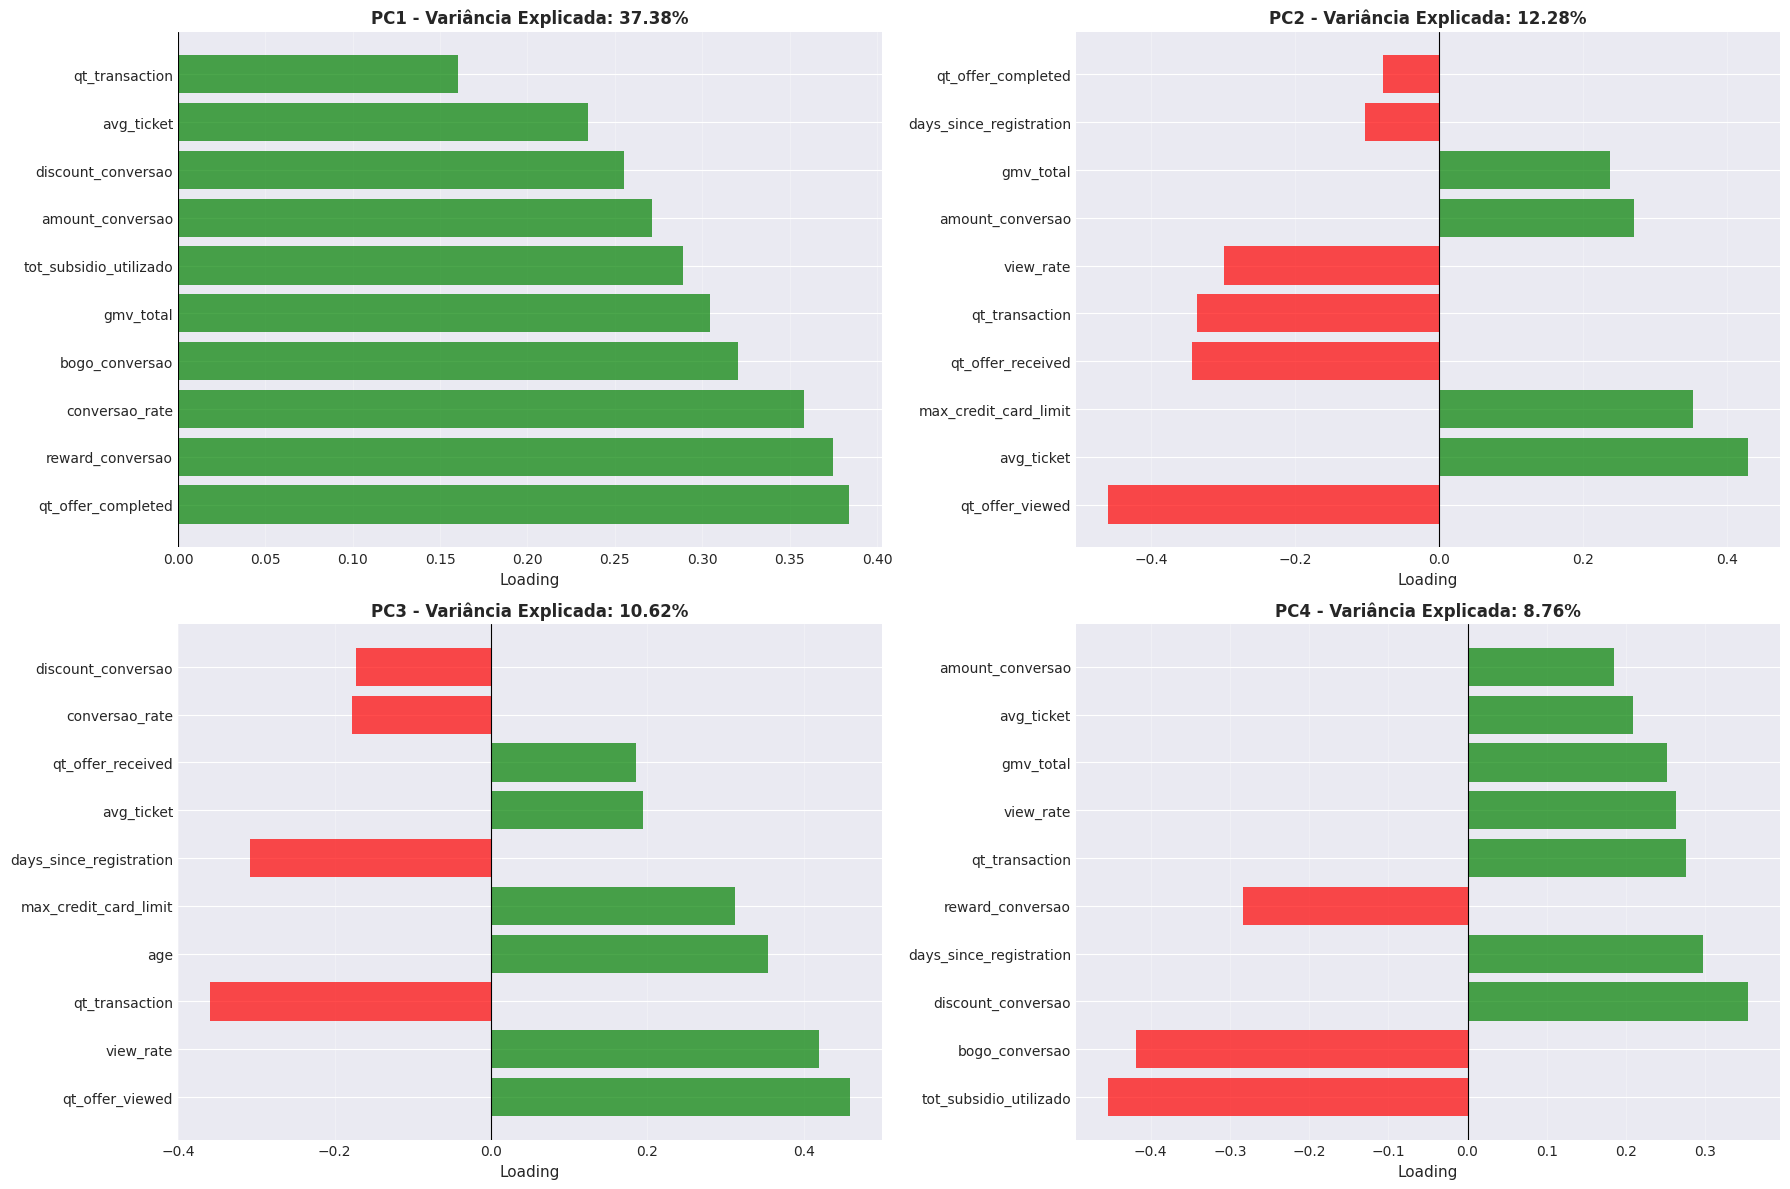

Interpretação dos componentes principais:

PC1: Representa principalmente características de engajamento e volume transacional
PC2: Captura informações sobre conversão e efetividade das campanhas
PC3-PC4: Capturam nuances adicionais do comportamento do cliente


In [0]:
import builtins
# Análise das loadings (pesos) do PCA
# Os loadings mostram como cada feature original contribui para cada componente principal o que ajuda a interpretar o significado de cada componente

loadings = pd.DataFrame(
    pca.components_.T,
    columns=pca_columns,
    index=df_features.columns
)

print(loadings)

# Visualização dos loadings dos primeiros 4 componentes
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for i in range(builtins.min(4, len(pca_columns))):
    # Ordenando features por magnitude de contribuição
    loadings_sorted = loadings[pca_columns[i]].abs().sort_values(ascending=False)
    # Recupera os sinais originais
    top_loadings = loadings[pca_columns[i]].loc[loadings_sorted.index].head(10)
    colors = ['green' if x > 0 else 'red' for x in top_loadings.values]
    
    axes[i].barh(range(len(top_loadings)), top_loadings.values, color=colors, alpha=0.7)
    axes[i].set_yticks(range(len(top_loadings)))
    axes[i].set_yticklabels(top_loadings.index)
    axes[i].set_xlabel('Loading', fontsize=11)
    axes[i].set_title(f'{pca_columns[i]} - Variância Explicada: {pca.explained_variance_ratio_[i]:.2%}',
                     fontsize=12, fontweight='bold')
    axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretação dos componentes principais:")
print("\nPC1: Representa principalmente características de engajamento e volume transacional")
print("PC2: Captura informações sobre conversão e efetividade das campanhas")
print("PC3-PC4: Capturam nuances adicionais do comportamento do cliente")

# 4.0 Determinação do Número Ótimo de Clusters

Utilizaremos três métodos para determinar o número ideal de clusters:

### 1. Método do Cotovelo (Elbow Method)

O Método do Cotovelo analisa a **inércia**, que corresponde à soma das distâncias quadráticas entre cada ponto e o centróide do cluster ao qual ele pertence.

O número ótimo de clusters é identificado visualmente no ponto onde a redução da inércia passa a ser menos significativa, formando um “cotovelo” no gráfico.



### 2. Silhouette Score

O Silhouette Score mede o quão similar uma observação é ao seu próprio cluster em comparação com outros clusters.

O valor do Silhouette Score varia entre -1 e 1:
- Valores próximos de 1 indicam boa separação entre clusters;
- Valores próximos de 0 indicam sobreposição;
- Valores negativos indicam possível má alocação.



### 3. Davies-Bouldin Index

O Davies-Bouldin Index avalia a razão entre a dispersão interna dos clusters e a separação entre eles.

Valores menores do índice indicam clusters mais compactos e melhor separados.


In [0]:
# Testando de 2 a 10 clusters e avaliar métricas de qualidade

k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Avaliando diferentes números de clusters...\n")

for k in k_range:
    # Aplicando K-means
    # random_state garante reprodutibilidade
    # n_init define o número de inicializações diferentes
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_pca)
    
    # Calculando métricas
    inertia = kmeans.inertia_
    silhouette = silhouette_score(df_pca, labels)
    davies_bouldin = davies_bouldin_score(df_pca, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    
    print(f"K={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}")



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b65b4a7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Avaliando diferentes números de clusters...



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b65b4a7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=2: Inertia=177549.76, Silhouette=0.275, Davies-Bouldin=1.446


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b65b4a7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=3: Inertia=159492.75, Silhouette=0.182, Davies-Bouldin=1.848


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b5ce336a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=4: Inertia=142765.88, Silhouette=0.188, Davies-Bouldin=1.605


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b7919bf60>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=5: Inertia=130606.98, Silhouette=0.159, Davies-Bouldin=1.616


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b5ce336a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=6: Inertia=119573.97, Silhouette=0.173, Davies-Bouldin=1.580


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b65b4a7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=7: Inertia=112680.92, Silhouette=0.171, Davies-Bouldin=1.553


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b65b4a7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=8: Inertia=106427.08, Silhouette=0.166, Davies-Bouldin=1.568


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b65b4a7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=9: Inertia=101828.45, Silhouette=0.166, Davies-Bouldin=1.567


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b7919bf60>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

K=10: Inertia=97997.00, Silhouette=0.164, Davies-Bouldin=1.554


In [0]:
    print(f"K={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}")

K=10: Inertia=97997.00, Silhouette=0.164, Davies-Bouldin=1.554


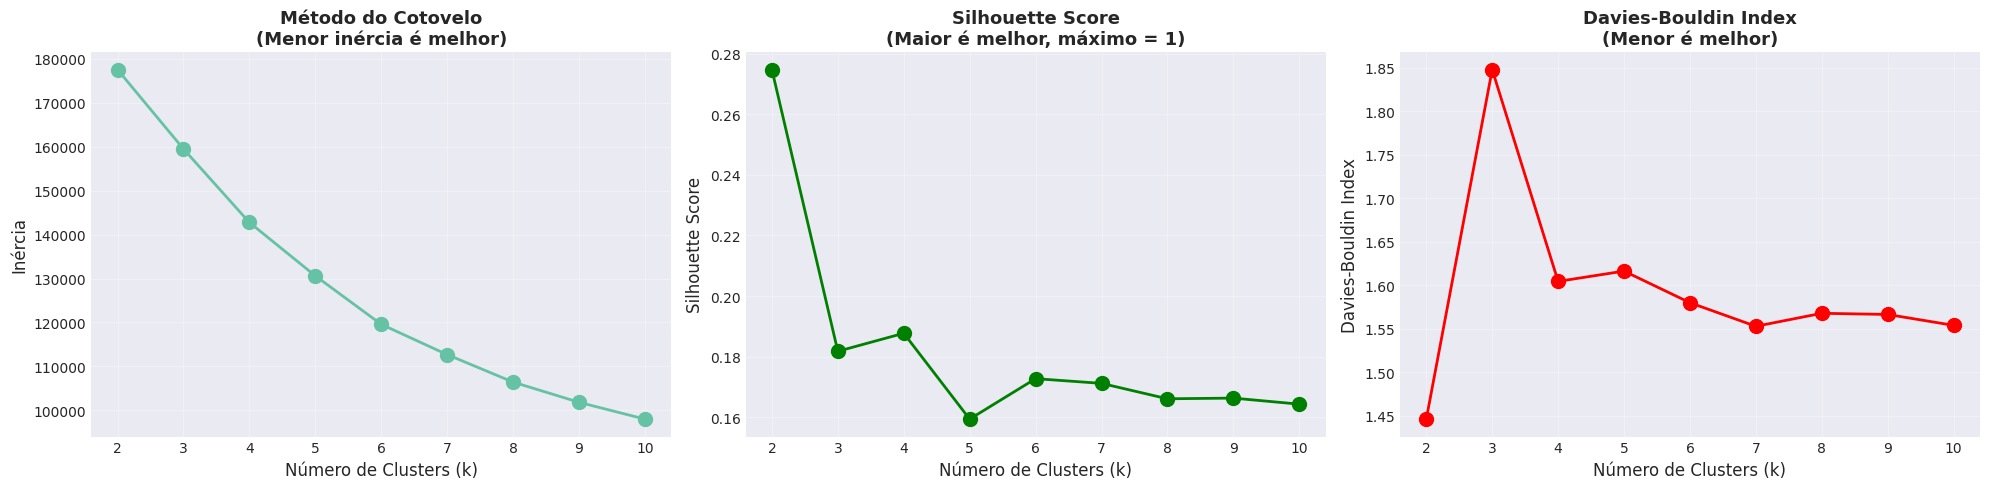


Recomendação baseada nas métricas:
- Melhor k segundo Silhouette Score: 2
- Melhor k segundo Davies-Bouldin: 2
- Melhor k observando o metodo do cotovelo é entre 4 e 5

Considerando o balanço entre interpretabilidade e qualidade dos clusters é recomendado usar k=4 ou k=5 clusters. Embora as métricas Silhouette Score e Davies-Bouldin indiquem k=2 como o valor ótimo do ponto de vista matemático, essa configuração resulta em uma segmentação muito agregada. O Método do Cotovelo indica um ponto de inflexão entre k=4 e k=5 que representam um melhor equilíbrio entre qualidade estatística e interpretabilidade.


In [0]:
# Visualização das métricas de avaliação
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Método do Cotovelo - Inércia
# O "cotovelo" indica onde adicionar mais clusters não traz ganho significativo
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=10)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inércia', fontsize=12)
axes[0].set_title('Método do Cotovelo\n(Menor inércia é melhor)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette Score
# Valores mais próximos de 1 indicam clusters bem definidos e separados
# Valores negativos indicam pontos atribuídos ao cluster errado
axes[1].plot(k_range, silhouette_scores, marker='o', color='green', linewidth=2, markersize=10)
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score\n(Maior é melhor, máximo = 1)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_range)

# Davies-Bouldin Index
# Valores menores indicam melhor separação entre clusters
axes[2].plot(k_range, davies_bouldin_scores, marker='o', color='red', linewidth=2, markersize=10)
axes[2].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Index\n(Menor é melhor)', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Identificando o melhor número de clusters baseado nas métricas
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_davies = k_range[np.argmin(davies_bouldin_scores)]

print(f"\nRecomendação baseada nas métricas:")
print(f"- Melhor k segundo Silhouette Score: {best_k_silhouette}")
print(f"- Melhor k segundo Davies-Bouldin: {best_k_davies}")
print(f"- Melhor k observando o metodo do cotovelo é entre 4 e 5")
print(f"\nConsiderando o balanço entre interpretabilidade e qualidade dos clusters é recomendado usar k=4 ou k=5 clusters. Embora as métricas Silhouette Score e Davies-Bouldin indiquem k=2 como o valor ótimo do ponto de vista matemático, essa configuração resulta em uma segmentação muito agregada. O Método do Cotovelo indica um ponto de inflexão entre k=4 e k=5 que representam um melhor equilíbrio entre qualidade estatística e interpretabilidade.")

# 5.0 Aplicação do K-means com Número Ótimo de Clusters

In [0]:
# Baseado na análise anterior, vamos usar k=4 para ter segmentos bem distintos e interpretáveis.

optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(df_pca)

# Adicionando os clusters ao dataframe original
df_model['cluster'] = clusters
df_pca['cluster'] = clusters




Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5b64c8fec0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

In [0]:
# Métricas de qualidade do modelo final
final_silhouette = silhouette_score(df_pca.drop('cluster', axis=1), clusters)
final_davies_bouldin = davies_bouldin_score(df_pca.drop('cluster', axis=1), clusters)


In [0]:
print(f"Modelo final com k={optimal_k} clusters")
print(f"Silhouette Score: {final_silhouette:.3f}")
print(f"Davies-Bouldin Index: {final_davies_bouldin:.3f}")
print(f"\nConclusão das métricas de avaliação:")
print(f"\nA segmentação obtida apresenta qualidade estatística aceitável para dados reais. O Silhouette Score por mais que não esteja tão próximo de 1 ainda indica separação moderada entre os clusters indica uma sobreposição natural entre os perfis, enquanto o Davies–Bouldin indica grupos razoavelmente compactos (aqui quanto menor melhor).")
print(f"\nDistribuição de clientes por cluster:")
print(df_model['cluster'].value_counts().sort_index())
print(f"\nPercentual de clientes por cluster:")
print((df_model['cluster'].value_counts(normalize=True) * 100).sort_index().round(2))

Modelo final com k=4 clusters
Silhouette Score: 0.188
Davies-Bouldin Index: 1.591

Conclusão das métricas de avaliação:

A segmentação obtida apresenta qualidade estatística aceitável para dados reais. O Silhouette Score por mais que não esteja tão próximo de 1 ainda indica separação moderada entre os clusters indica uma sobreposição natural entre os perfis, enquanto o Davies–Bouldin indica grupos razoavelmente compactos (aqui quanto menor melhor).

Distribuição de clientes por cluster:
0    5802
1    7053
2    3943
3     202
Name: cluster, dtype: int64

Percentual de clientes por cluster:
0    34.13
1    41.49
2    23.19
3     1.19
Name: cluster, dtype: float64


# 6.0 Visualização dos Clusters

Vamos visualizar os clusters em diferentes perspectivas usando os componentes principais.

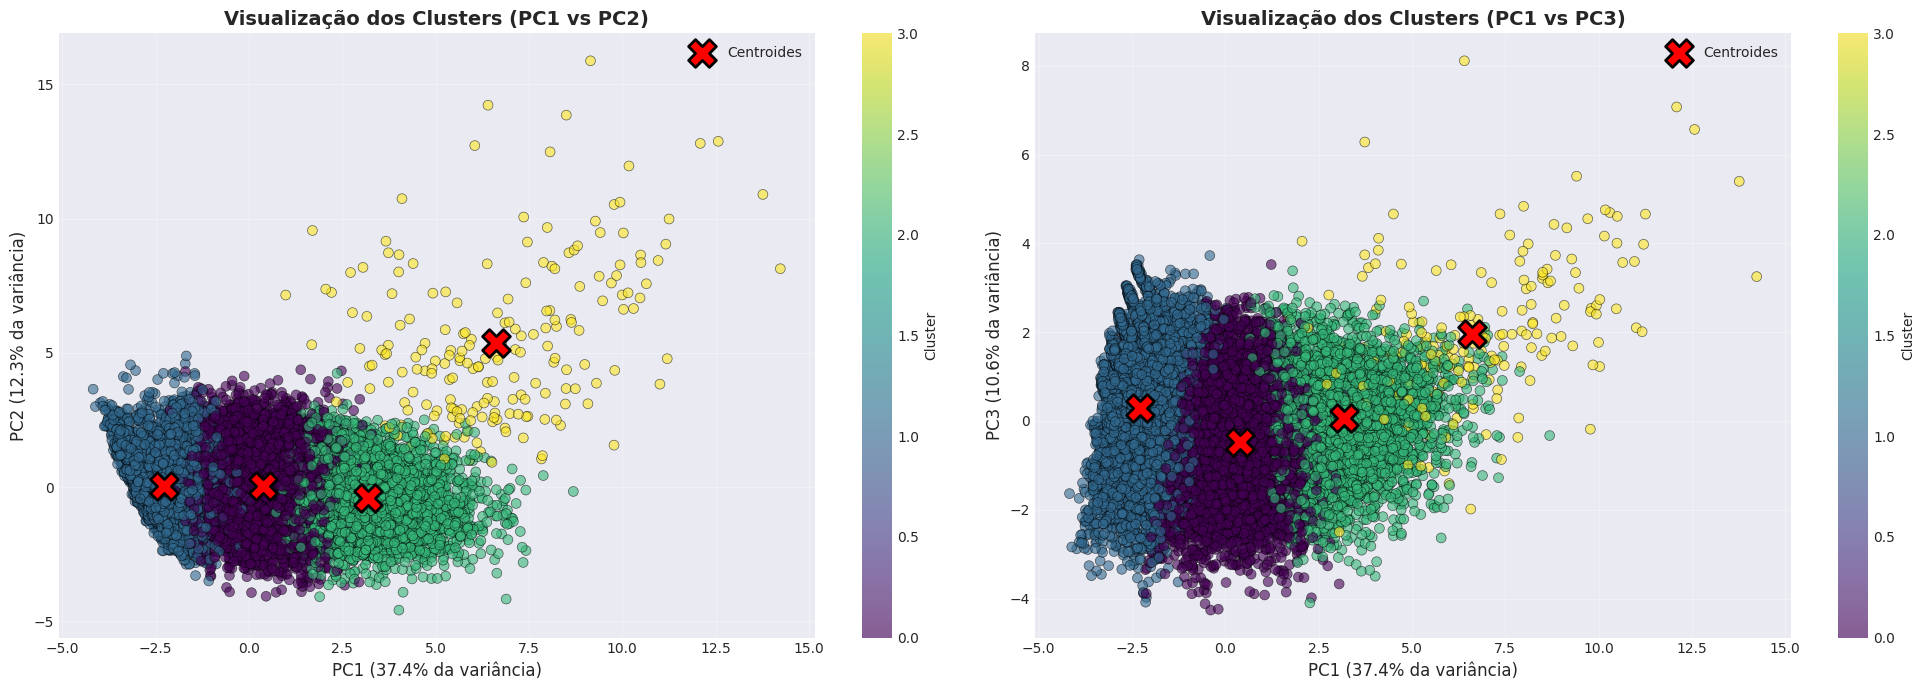

In [0]:
# Visualização dos clusters nos dois primeiros componentes principais PC1 e PC2 são os que capturam a maior parte da variância

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: PC1 vs PC2
scatter1 = axes[0].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=df_pca['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

# Plotando os centroides
centroids_2d = kmeans_final.cluster_centers_[:, :2]
axes[0].scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c='red',
    marker='X',
    s=400,
    edgecolors='black',
    linewidth=2,
    label='Centroides'
)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} da variância)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} da variância)', fontsize=12)
axes[0].set_title('Visualização dos Clusters (PC1 vs PC2)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: PC1 vs PC3
scatter2 = axes[1].scatter(
    df_pca['PC1'],
    df_pca['PC3'],
    c=df_pca['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

centroids_pc13 = kmeans_final.cluster_centers_[:, [0, 2]]
axes[1].scatter(
    centroids_pc13[:, 0],
    centroids_pc13[:, 1],
    c='red',
    marker='X',
    s=400,
    edgecolors='black',
    linewidth=2,
    label='Centroides'
)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} da variância)', fontsize=12)
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} da variância)', fontsize=12)
axes[1].set_title('Visualização dos Clusters (PC1 vs PC3)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

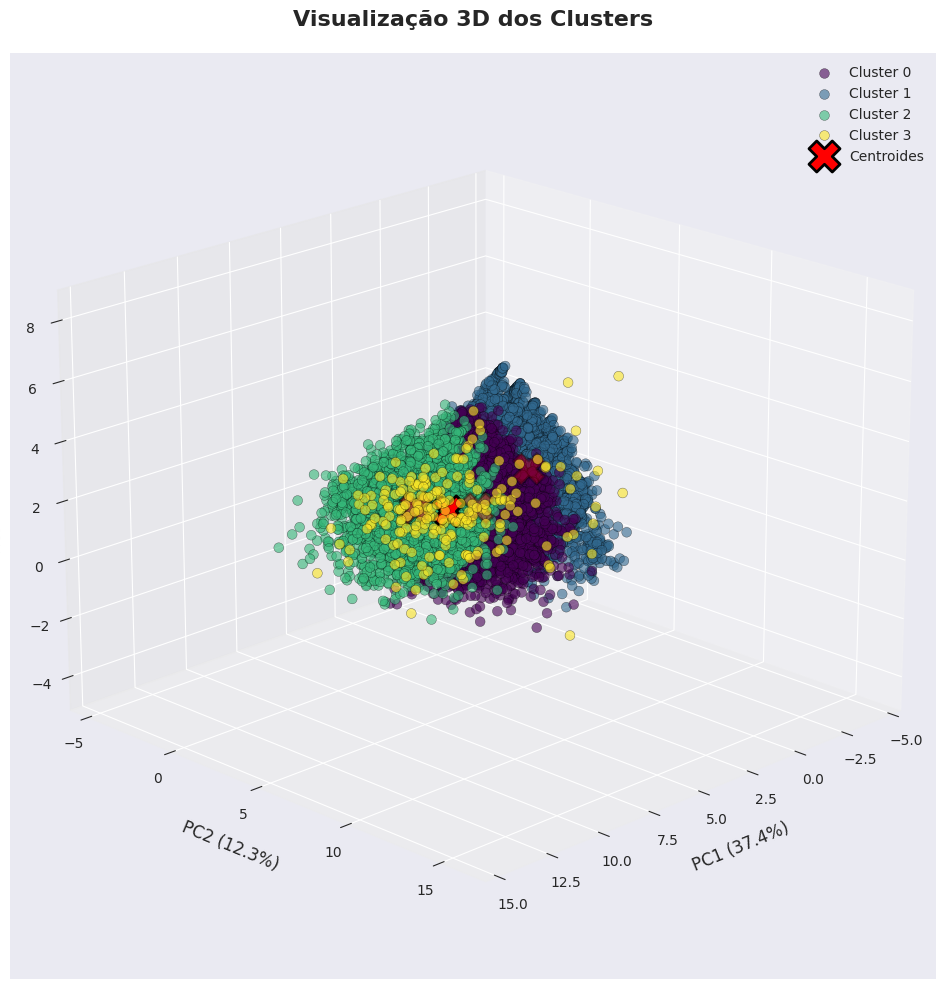

Os clusters mostram separação clara no espaço tridimensional dos componentes principais.
Cada cluster representa um perfil distinto de comportamento de cliente.


In [0]:
# Visualização 3D interativa dos três primeiros componentes principais para ajudar a entender a separação espacial dos clusters

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotando cada cluster com cor diferente
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == i]
    ax.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        cluster_data['PC3'],
        c=[colors[i]],
        label=f'Cluster {i}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.3
    )

# Plotando centroides
centroids_3d = kmeans_final.cluster_centers_[:, :3]
ax.scatter(
    centroids_3d[:, 0],
    centroids_3d[:, 1],
    centroids_3d[:, 2],
    c='red',
    marker='X',
    s=500,
    edgecolors='black',
    linewidth=2,
    label='Centroides'
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12, labelpad=10)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12, labelpad=10)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=12, labelpad=10)
ax.set_title('Visualização 3D dos Clusters', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print("Os clusters mostram separação clara no espaço tridimensional dos componentes principais.")
print("Cada cluster representa um perfil distinto de comportamento de cliente.")

# 7.0 Análise de Perfil dos Clusters

Agora vamos caracterizar cada cluster analisando as features originais.
Isso ajuda nos permitirá entender o perfil de clientes em cada segmento.

In [0]:
# Análise estatística dos clusters
# Calculando médias das features mais importantes por cluster

features_analysis = [
    'age',
    'gmv_total',
    'days_since_registration',
    'max_credit_card_limit',
    'qt_transaction',
    'qt_offer_received',
    'qt_offer_viewed',
    'qt_offer_completed',
    'conversao_rate',
    'view_rate',
    'avg_ticket',
    'tot_subsidio_utilizado',
    'reward_conversao'
]

# Criando resumo estatístico por cluster
cluster_summary = df_model.groupby('cluster')[features_analysis].mean().round(2)

print("Perfil médio de cada cluster:")
cluster_summary

Perfil médio de cada cluster:


,age,gmv_total,days_since_registration,max_credit_card_limit,qt_transaction,qt_offer_received,qt_offer_viewed,qt_offer_completed,conversao_rate,view_rate,avg_ticket,tot_subsidio_utilizado,reward_conversao
cluster,,,,,,,,,,,,,
0,56.58,115.27,3377.86,67165.75,9.69,4.26,3.29,2.39,0.58,0.78,15.05,10.05,10.05
1,70.54,27.84,3084.11,57109.54,5.97,4.36,3.12,1.09,0.26,0.72,5.73,4.49,4.49
2,57.11,190.94,3315.57,72815.38,10.48,5.05,4.17,4.04,0.81,0.83,19.44,22.84,22.84
3,59.42,837.34,3285.96,81257.43,9.23,4.65,3.74,3.51,0.76,0.81,110.92,18.36,18.36


In [0]:
df_model.head()

,account_id,age,gender,gmv_total,days_since_registration,max_credit_card_limit,tot_subsidio_utilizado,qt_offer_completed,qt_offer_received,qt_offer_viewed,qt_transaction,channels_frequency_conversao,channel_web_frequency_conversao,channel_email_frequency_conversao,channel_mobile_frequency_conversao,channel_social_frequency_conversao,bogo_conversao,discount_conversao,informational_conversao,avg_discount_value_conversao,avg_duration_conversao,avg_min_value_conversao,reward_conversao,amount_conversao,qt_transacional_conversao,min_time_conversao,max_time_conversao,conversao_rate,view_rate,avg_ticket,cluster
0,03833a1fe27f4435917da7e54c6fa48a,118,None,2.38,2848.0,NaN,NaN,NaN,4.0,4.0,2.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.190000,1
1,dd69125d21a54693840469a1ad6ca243,66,M,15.99,3005.0,32000.0,3.0,1.0,3.0,3.0,6.0,"[{'channel': 'web', 'frequency': 1}, {'channel...",1.0,1.0,1.0,1.0,0.0,1.0,0.0,3.000000,7.0,7.0,3.0,4.20,1.0,4.00,4.00,0.333333,1.000000,2.665000,1
2,3d55f046a320408db9a88be59acc19cc,118,None,24.46,3431.0,NaN,2.0,1.0,6.0,4.0,12.0,"[{'channel': 'web', 'frequency': 1}, {'channel...",1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.000000,10.0,10.0,2.0,2.59,1.0,25.00,25.00,0.166667,0.666667,2.038333,1
3,752045b74388467d99a44eac9501116e,43,F,14.23,3044.0,42000.0,NaN,NaN,5.0,2.0,5.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,2.846000,1
4,b66cb315b9944a749e25aee0d7dfe13c,87,M,84.95,2902.0,33000.0,7.0,3.0,6.0,5.0,9.0,"[{'channel': 'web', 'frequency': 3}, {'channel...",3.0,3.0,3.0,2.0,0.0,3.0,0.0,2.333333,8.0,9.0,7.0,24.36,3.0,17.25,28.75,0.500000,0.833333,9.438889,0


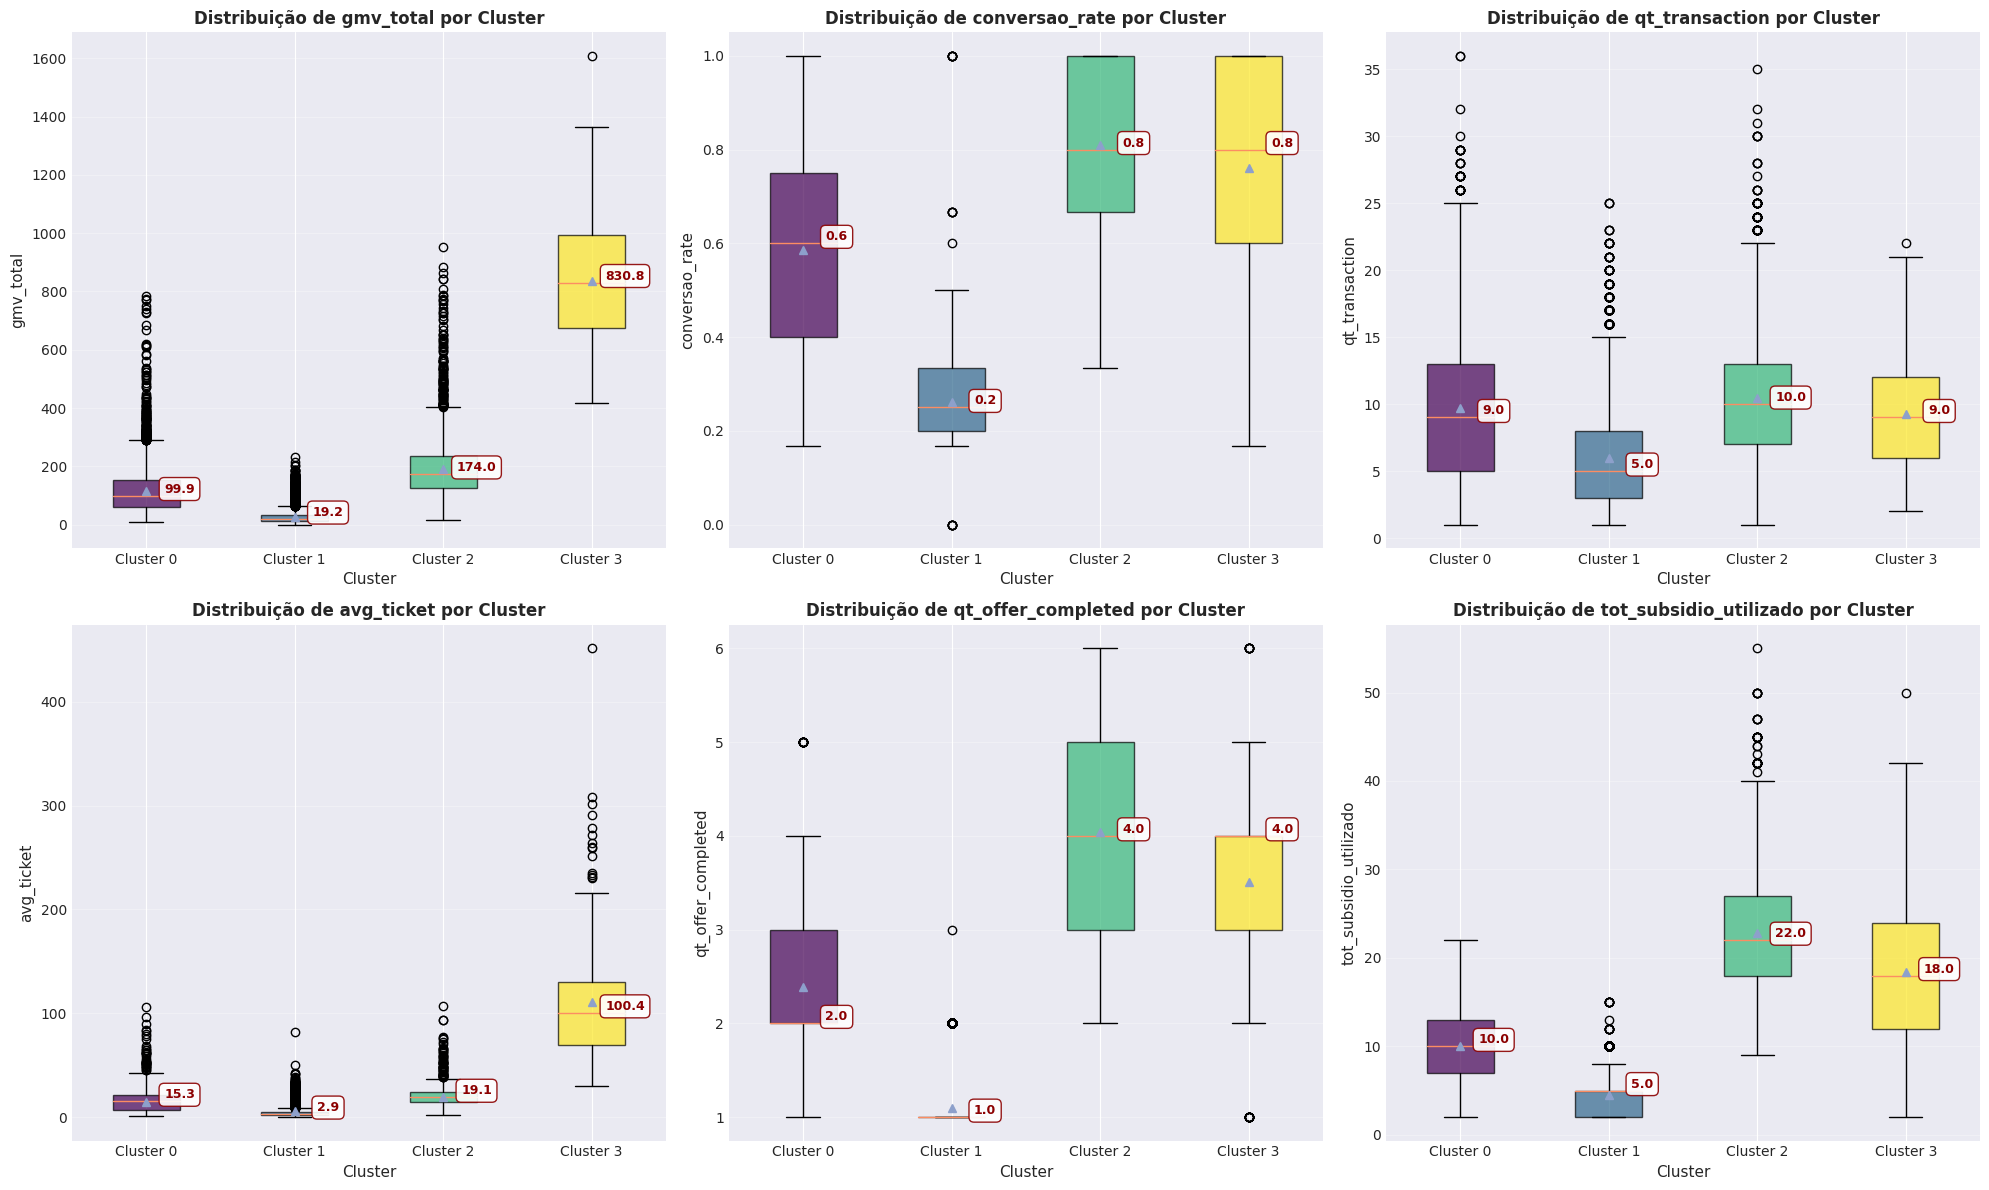

In [0]:
# Visualização comparativa dos clusters para features-chave

key_features = [
    'gmv_total',
    'conversao_rate',
    'qt_transaction',
    'avg_ticket',
    'qt_offer_completed',
    'tot_subsidio_utilizado'
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    # Criando boxplot para cada feature por cluster
    data_to_plot = [df_model[df_model['cluster'] == i][feature].dropna() 
                    for i in range(optimal_k)]
    
    bp = axes[idx].boxplot(data_to_plot, 
                           labels=[f'Cluster {i}' for i in range(optimal_k)],
                           patch_artist=True,
                           showmeans=True)
    
    # Colorindo os boxplots
    colors_box = plt.cm.viridis(np.linspace(0, 1, optimal_k))
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Adicionando labels de mediana com fundo
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]  # Pega a coordenada da linha da mediana
        median_value = data_to_plot[i].median()
        axes[idx].text(x, y, f'{median_value:.1f}', 
                      ha='center', va='bottom', 
                      fontsize=9, fontweight='bold',
                      color='darkred',
                      bbox=dict(boxstyle='round,pad=0.4', 
                               facecolor='white', 
                               edgecolor='darkred',
                               alpha=0.9))
    
    axes[idx].set_xlabel('Cluster', fontsize=11)
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_title(f'Distribuição de {feature} por Cluster', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

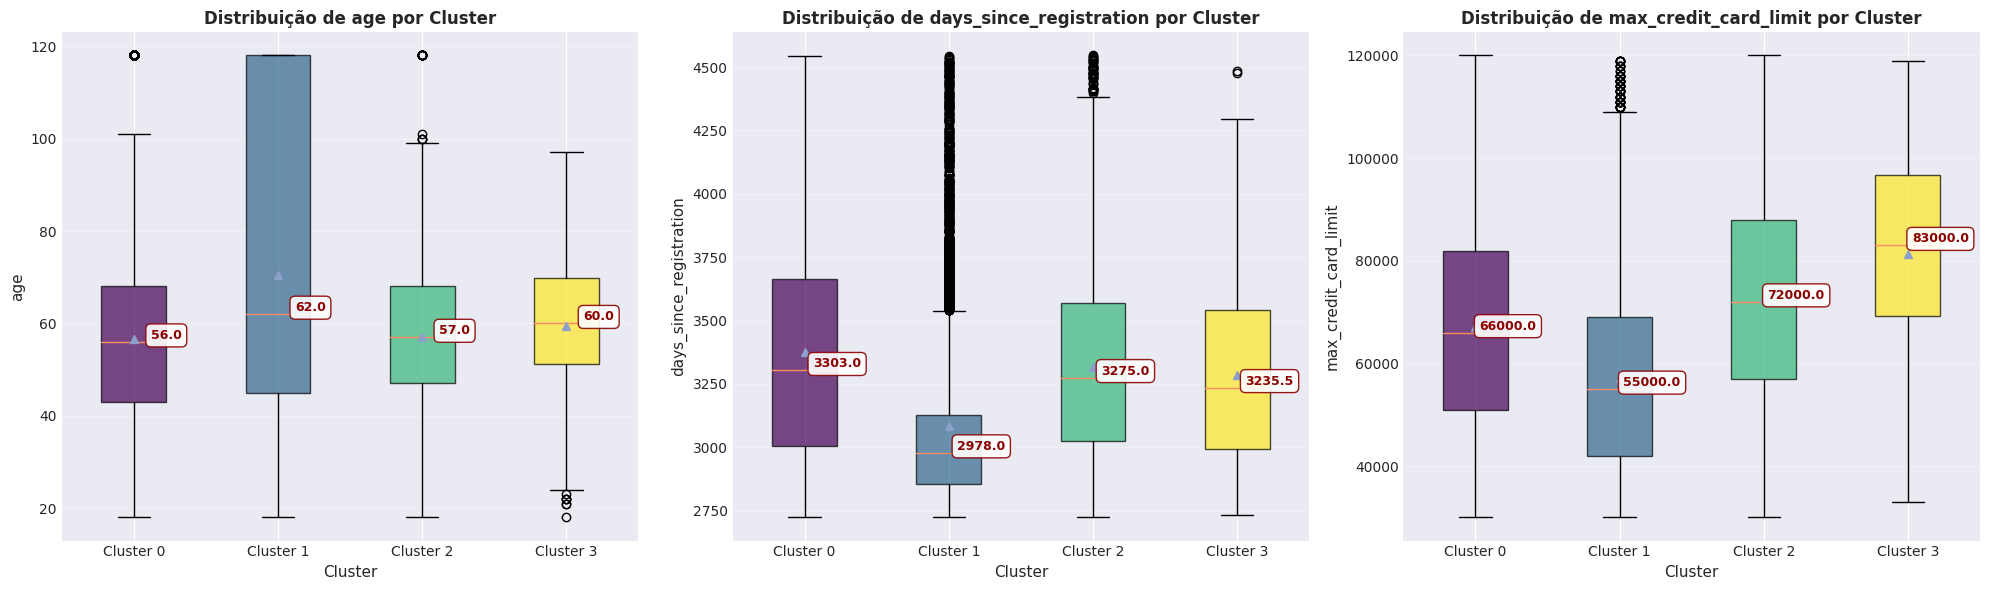

In [0]:
# Visualização comparativa dos clusters demografia

demografia_features = [
'age', 'days_since_registration', 'max_credit_card_limit'
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.ravel()

for idx, feature in enumerate(demografia_features):
    # Criando boxplot para cada feature por cluster
    data_to_plot = [df_model[df_model['cluster'] == i][feature].dropna() 
                    for i in range(optimal_k)]
    
    bp = axes[idx].boxplot(data_to_plot, 
                           labels=[f'Cluster {i}' for i in range(optimal_k)],
                           patch_artist=True,
                           showmeans=True)
    
    # Colorindo os boxplots
    colors_box = plt.cm.viridis(np.linspace(0, 1, optimal_k))
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Adicionando labels de mediana com fundo
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]  # Pega a coordenada da linha da mediana
        median_value = data_to_plot[i].median()
        axes[idx].text(x, y, f'{median_value:.1f}', 
                      ha='center', va='bottom', 
                      fontsize=9, fontweight='bold',
                      color='darkred',
                      bbox=dict(boxstyle='round,pad=0.4', 
                               facecolor='white', 
                               edgecolor='darkred',
                               alpha=0.9))
    
    axes[idx].set_xlabel('Cluster', fontsize=11)
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_title(f'Distribuição de {feature} por Cluster', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [0]:
# Análise de taxa de conversão e engajamento por cluster, importante para identificar oportunidades de aumento de receita

conversao_metrics = df_model.groupby('cluster').agg({
    'conversao_rate': 'mean',
    'view_rate': 'mean',
    'qt_offer_completed': 'sum',
    'qt_offer_received': 'sum',
    'gmv_total': 'sum',
    'tot_subsidio_utilizado': 'sum',
    'account_id': 'count'
}).round(3)

conversao_metrics.columns = [
    'taxa_conversao_media',
    'taxa_visualizacao_media',
    'total_ofertas_completadas',
    'total_ofertas_recebidas',
    'gmv_total',
    'subsidio_total_utilizado',
    'numero_clientes'
]

# Calculando métricas adicionais
conversao_metrics['gmv_por_cliente'] = (conversao_metrics['gmv_total'] / 
                                          conversao_metrics['numero_clientes']).round(2)
conversao_metrics['subsidio_por_cliente'] = (conversao_metrics['subsidio_total_utilizado'] / 
                                               conversao_metrics['numero_clientes']).round(2)
conversao_metrics['roi_subsidio'] = (conversao_metrics['gmv_total'] / 
                                       conversao_metrics['subsidio_total_utilizado']).round(2)

print("Métricas de conversão e receita por cluster:")
conversao_metrics

Métricas de conversão e receita por cluster:


,taxa_conversao_media,taxa_visualizacao_media,total_ofertas_completadas,total_ofertas_recebidas,gmv_total,subsidio_total_utilizado,numero_clientes,gmv_por_cliente,subsidio_por_cliente,roi_subsidio
cluster,,,,,,,,,,
0,0.585,0.781,13859.0,24733.0,668804.81,58263.0,5802,115.27,10.04,11.48
1,0.262,0.718,3100.0,30708.0,184632.25,12719.0,7053,26.18,1.80,14.52
2,0.810,0.831,15928.0,19896.0,752872.73,90077.0,3943,190.94,22.84,8.36
3,0.761,0.806,692.0,940.0,169142.18,3617.0,202,837.34,17.91,46.76


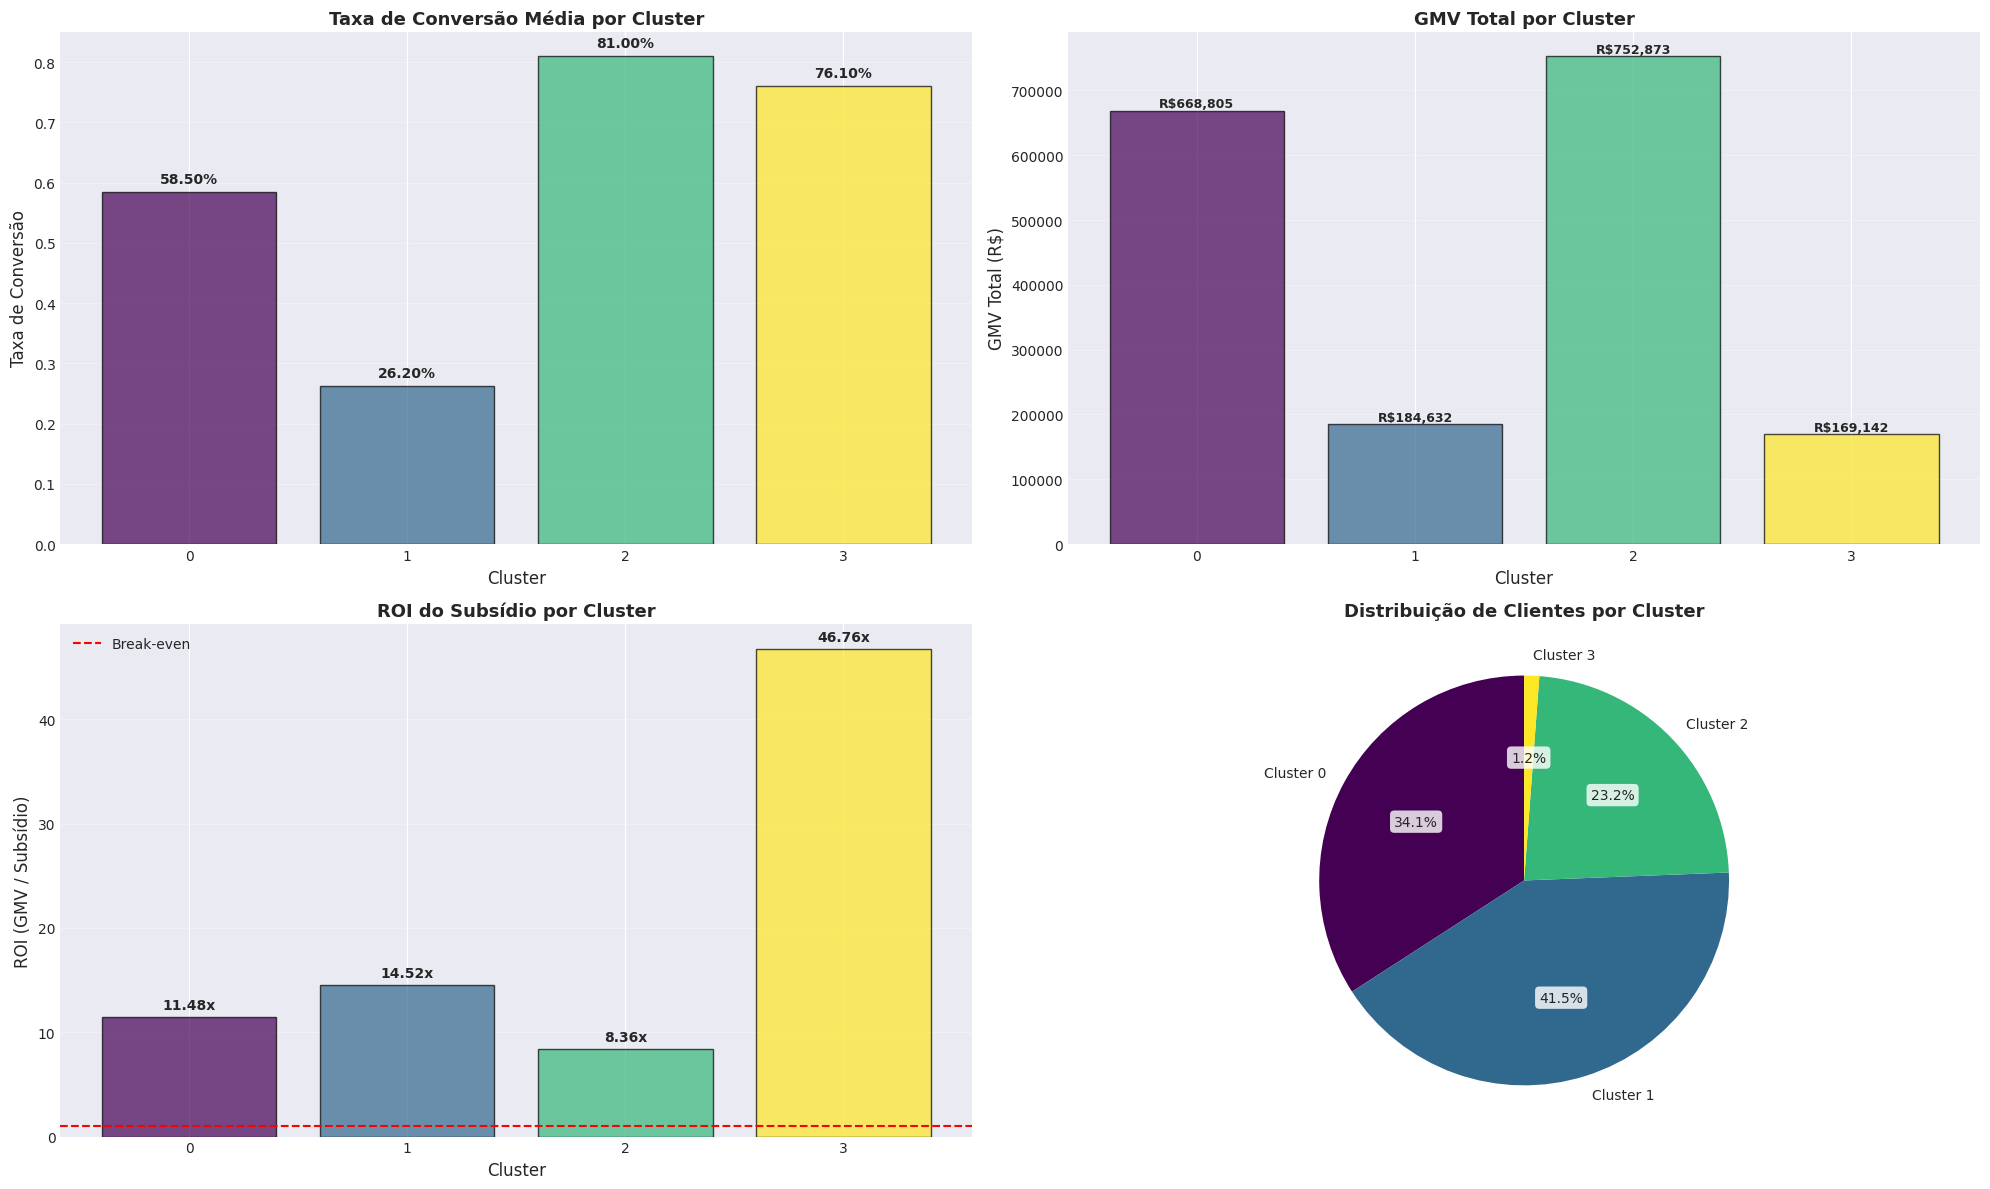


Análises:
Cluster com melhor taxa de conversão: 2 (81.00%)
Cluster com pior taxa de conversão: 1 (26.20%)
Cluster com maior GMV: 2 (R$ 752,872.73)


In [0]:
# Visualização das métricas de negócio por cluster

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Taxa de conversão média por cluster
axes[0, 0].bar(range(optimal_k), 
               conversao_metrics['taxa_conversao_media'],
               color=colors,
               alpha=0.7,
               edgecolor='black')
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Taxa de Conversão', fontsize=12)
axes[0, 0].set_title('Taxa de Conversão Média por Cluster', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(range(optimal_k))
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(conversao_metrics['taxa_conversao_media']):
    axes[0, 0].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

# 2. GMV total por cluster
axes[0, 1].bar(range(optimal_k), 
               conversao_metrics['gmv_total'],
               color=colors,
               alpha=0.7,
               edgecolor='black')
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('GMV Total (R$)', fontsize=12)
axes[0, 1].set_title('GMV Total por Cluster', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(range(optimal_k))
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(conversao_metrics['gmv_total']):
    axes[0, 1].text(i, v + 500, f'R${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. ROI do subsídio por cluster
axes[1, 0].bar(range(optimal_k), 
               conversao_metrics['roi_subsidio'],
               color=colors,
               alpha=0.7,
               edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('ROI (GMV / Subsídio)', fontsize=12)
axes[1, 0].set_title('ROI do Subsídio por Cluster', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(optimal_k))
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=1, color='red', linestyle='--', label='Break-even')
axes[1, 0].legend()
for i, v in enumerate(conversao_metrics['roi_subsidio']):
    if not np.isnan(v) and not np.isinf(v):
        axes[1, 0].text(i, v + 0.5, f'{v:.2f}x', ha='center', va='bottom', fontweight='bold')

# 4. Número de clientes por cluster (proporção)
axes[1, 1].pie(conversao_metrics['numero_clientes'], 
               labels=[f'Cluster {i}' for i in range(optimal_k)],
               autopct='%1.1f%%',
               colors=colors,
               startangle=90,
               textprops={'bbox': dict(boxstyle='round,pad=0.3', 
                                       facecolor='white', 
                                       edgecolor='none',
                                       alpha=0.8)})
axes[1, 1].set_title('Distribuição de Clientes por Cluster', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAnálises:")

best_conversao_cluster = conversao_metrics['taxa_conversao_media'].idxmax()
worst_conversao_cluster = conversao_metrics['taxa_conversao_media'].idxmin()
highest_gmv_cluster = conversao_metrics['gmv_total'].idxmax()

print(f"Cluster com melhor taxa de conversão: {best_conversao_cluster} ({conversao_metrics.loc[best_conversao_cluster, 'taxa_conversao_media']:.2%})")
print(f"Cluster com pior taxa de conversão: {worst_conversao_cluster} ({conversao_metrics.loc[worst_conversao_cluster, 'taxa_conversao_media']:.2%})")
print(f"Cluster com maior GMV: {highest_gmv_cluster} (R$ {conversao_metrics.loc[highest_gmv_cluster, 'gmv_total']:,.2f})")

# 8.0 Caracterização Detalhada dos Clusters

Vamos criar personas para cada cluster, facilitando a comunicação com stakeholders.

In [0]:
# Função para criar perfil de cada cluster
def create_cluster_persona(cluster_id, data):
    cluster_data = data[data['cluster'] == cluster_id]
    
    # Calculando estatísticas 
    size = len(cluster_data)
    pct_total = (size / len(data)) * 100
    min_age = cluster_data['age'].min()
    max_age = cluster_data['age'].max() 
    avg_age = cluster_data['age'].mean()
    avg_gmv = cluster_data['gmv_total'].mean()
    avg_transactions = cluster_data['qt_transaction'].mean()
    avg_ticket = cluster_data['avg_ticket'].mean()
    conversao_rate = cluster_data['conversao_rate'].mean()
    view_rate = cluster_data['view_rate'].mean()
    avg_offers_completed = cluster_data['qt_offer_completed'].mean()
    avg_credit_limit = cluster_data['max_credit_card_limit'].mean()
    
    # Distribuição de gênero
    gender_dist = cluster_data['gender'].value_counts(normalize=True) * 100
    
    persona = {
        'cluster_id': cluster_id,
        'size': size,
        'pct_total': pct_total,
        'avg_age': avg_age,
        'avg_gmv': avg_gmv,
        'avg_transactions': avg_transactions,
        'avg_ticket': avg_ticket,
        'conversao_rate': conversao_rate,
        'view_rate': view_rate,
        'avg_offers_completed': avg_offers_completed,
        'avg_credit_limit': avg_credit_limit,
        'gender_dist': gender_dist,
        'min_age': min_age,
        'max_age': max_age,
        'gender_dist': gender_dist
    }
    
    return persona

# Criando personas para todos os clusters
personas = []
for i in range(optimal_k):
    persona = create_cluster_persona(i, df_model)
    personas.append(persona)
    
  
    print(f"CLUSTER {i} - PERFIL")

    print(f"\nTamanho: {persona['size']:,} clientes ({persona['pct_total']:.1f}% da base)")
    print(f"\nDemografia:")
    print(f"  - Idade média: {persona['avg_age']:.0f} anos")
    print(f"  - Idade mínima: {persona['min_age']}")
    print(f"  - Idade máxima: {persona['max_age']}")
    print(f"  - Distribuição de gênero: \n{persona['gender_dist']}")
    print(f"  - Limite médio de crédito: R$ {persona['avg_credit_limit']:,.2f}")
    print(f"\nComportamento Transacional:")
    print(f"  - GMV médio: R$ {persona['avg_gmv']:.2f}")
    print(f"  - Transações médias: {persona['avg_transactions']:.1f}")
    print(f"  - Ticket médio: R$ {persona['avg_ticket']:.2f}")
    print(f"\nEngajamento com Ofertas:")
    print(f"  - Taxa de conversão: {persona['conversao_rate']:.2%}")
    print(f"  - Taxa de visualização: {persona['view_rate']:.2%}")
    print(f"  - Ofertas completadas em média: {persona['avg_offers_completed']:.1f}")

CLUSTER 0 - PERFIL

Tamanho: 5,802 clientes (34.1% da base)

Demografia:
  - Idade média: 57 anos
  - Idade mínima: 18
  - Idade máxima: 118
  - Distribuição de gênero: 
M    54.179291
F    44.466227
O     1.354482
Name: gender, dtype: float64
  - Limite médio de crédito: R$ 67,165.75

Comportamento Transacional:
  - GMV médio: R$ 115.27
  - Transações médias: 9.7
  - Ticket médio: R$ 15.05

Engajamento com Ofertas:
  - Taxa de conversão: 58.47%
  - Taxa de visualização: 78.13%
  - Ofertas completadas em média: 2.4
CLUSTER 1 - PERFIL

Tamanho: 7,053 clientes (41.5% da base)

Demografia:
  - Idade média: 71 anos
  - Idade mínima: 18
  - Idade máxima: 118
  - Distribuição de gênero: 
M    69.065880
F    29.695182
O     1.238938
Name: gender, dtype: float64
  - Limite médio de crédito: R$ 57,109.54

Comportamento Transacional:
  - GMV médio: R$ 27.84
  - Transações médias: 6.0
  - Ticket médio: R$ 5.73

Engajamento com Ofertas:
  - Taxa de conversão: 26.15%
  - Taxa de visualização: 71.84

# 9.0 Análises Cluster 1

ANÁLISE DE TAXA DE CONVERSÃO POR COMBINAÇÃO CANAL + TIPO DE OFERTA

Total de clientes no Cluster 1: 7053
Taxa de conversão média do cluster: 26.15%
RANKING COMPLETO: TAXA DE CONVERSÃO POR COMBINAÇÃO

SOCIAL + BOGO
   • Taxa de Conversão: 27.86%
   • Mediana: 25.00%
   • Desvio Padrão: 9.85%
   • N clientes: 840 (11.9% da base)

WEB + BOGO
   • Taxa de Conversão: 27.57%
   • Mediana: 25.00%
   • Desvio Padrão: 10.13%
   • N clientes: 1,111 (15.8% da base)

EMAIL + BOGO
   • Taxa de Conversão: 27.37%
   • Mediana: 25.00%
   • Desvio Padrão: 9.93%
   • N clientes: 1,279 (18.1% da base)

MOBILE + BOGO
   • Taxa de Conversão: 27.37%
   • Mediana: 25.00%
   • Desvio Padrão: 9.93%
   • N clientes: 1,279 (18.1% da base)

SOCIAL + DISCOUNT
   • Taxa de Conversão: 26.49%
   • Mediana: 25.00%
   • Desvio Padrão: 9.86%
   • N clientes: 1,276 (18.1% da base)

WEB + DISCOUNT
   • Taxa de Conversão: 26.41%
   • Mediana: 25.00%
   • Desvio Padrão: 9.52%
   • N clientes: 1,687 (23.9% da base)

EMAIL + 

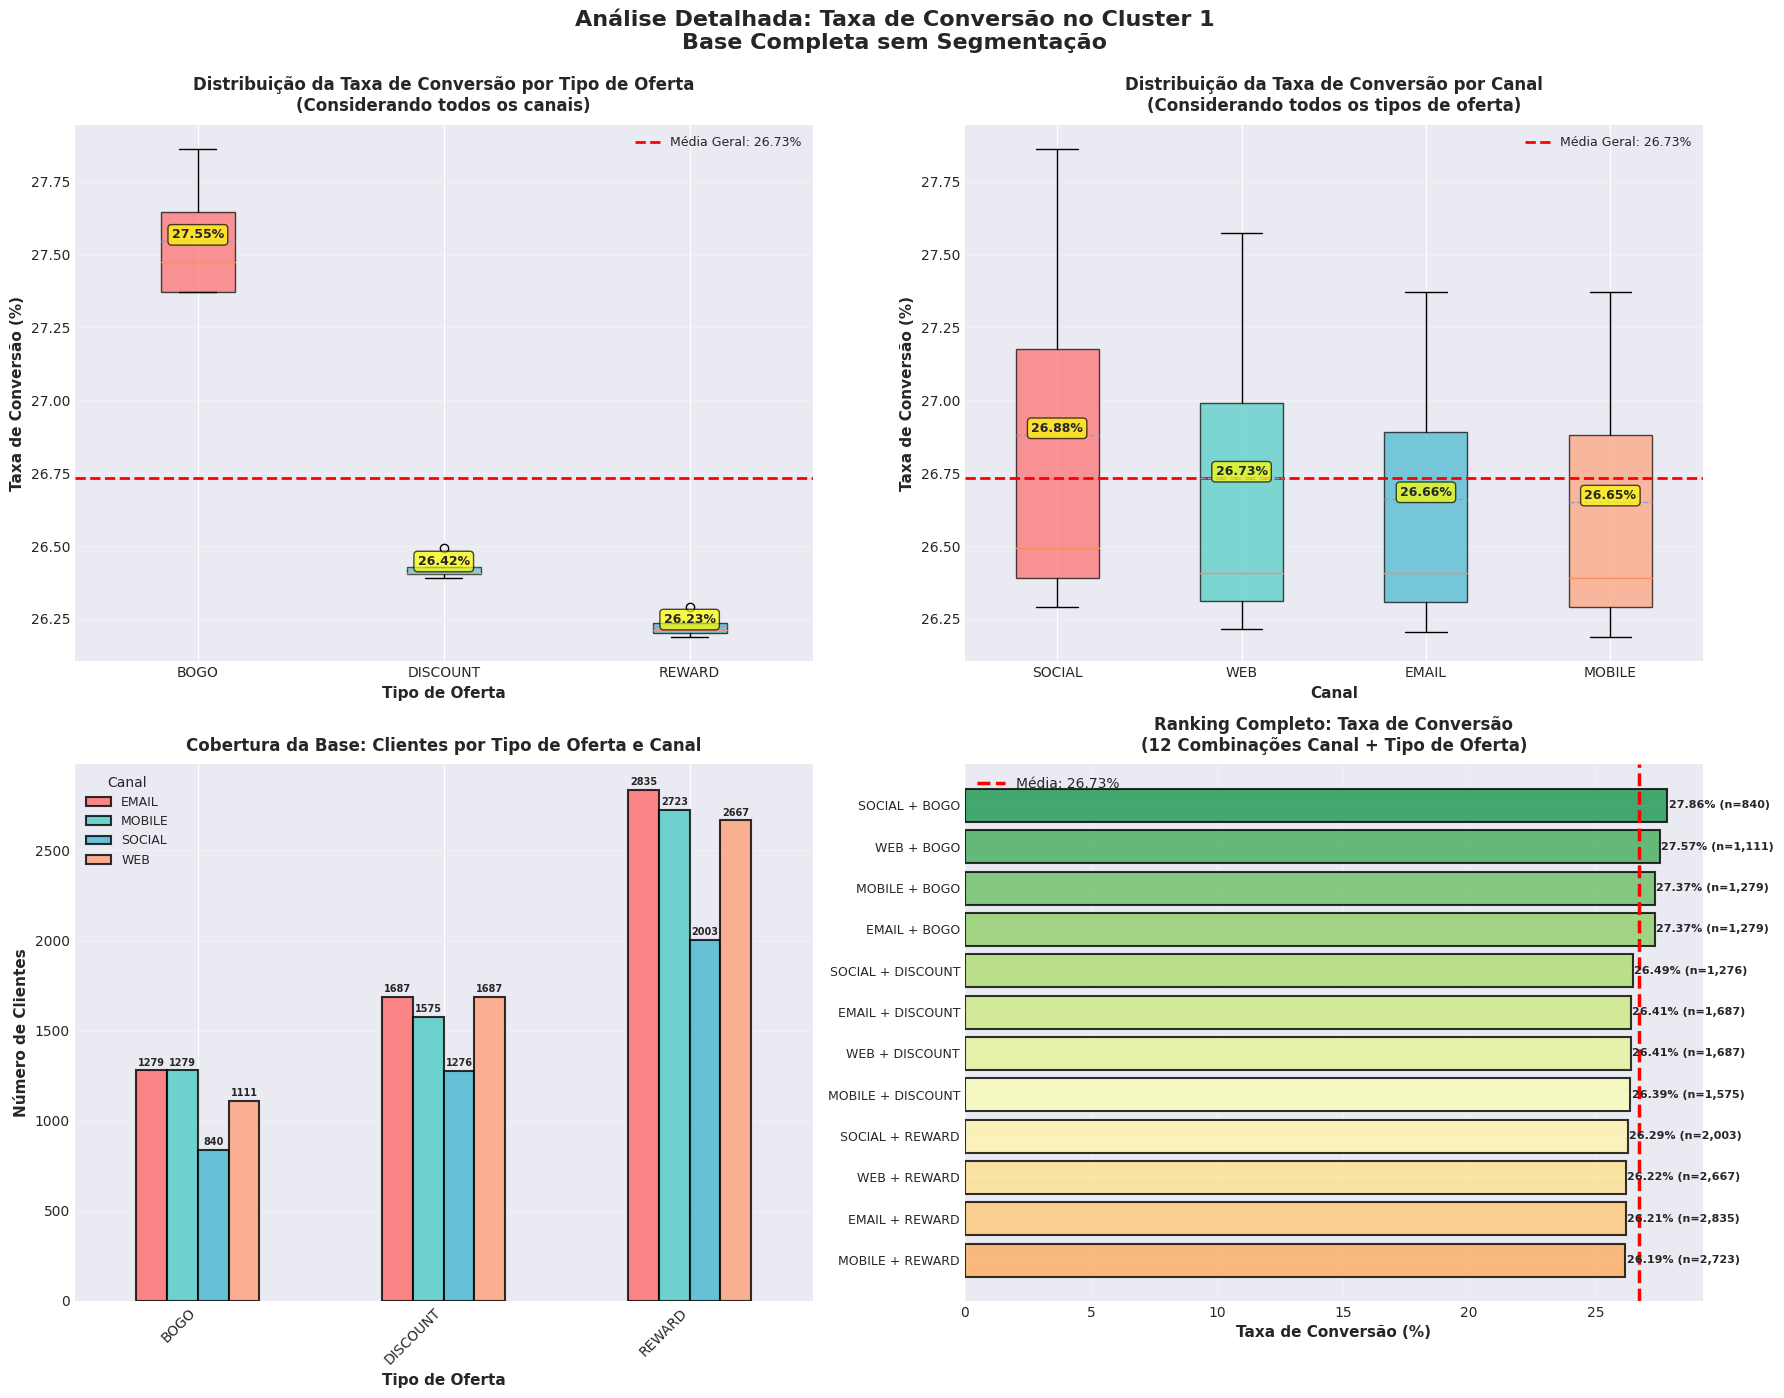

Canal,Tipo_Oferta,Combinacao,Taxa_Conversao,Desvio_Padrao,Mediana,N_Clientes,Percentual_Base
SOCIAL,BOGO,SOCIAL + BOGO,0.2786111111111111,0.09849645511824459,0.25,840,11.909825606125054
WEB,BOGO,WEB + BOGO,0.2757425742574257,0.10134918744819946,0.25,1111,15.752162200482065
EMAIL,BOGO,EMAIL + BOGO,0.2737294761532447,0.09925859465645887,0.25,1279,18.134127321707076
MOBILE,BOGO,MOBILE + BOGO,0.2737294761532447,0.09925859465645887,0.25,1279,18.134127321707076
SOCIAL,DISCOUNT,SOCIAL + DISCOUNT,0.2649164054336468,0.0986222386059256,0.25,1276,18.09159223025663
WEB,DISCOUNT,WEB + DISCOUNT,0.26407824540604624,0.09516562568704412,0.25,1687,23.918899758967815
EMAIL,DISCOUNT,EMAIL + DISCOUNT,0.26407824540604624,0.09516562568704412,0.25,1687,23.918899758967815
MOBILE,DISCOUNT,MOBILE + DISCOUNT,0.26391534391534394,0.09604184667733878,0.25,1575,22.330923011484476
SOCIAL,REWARD,SOCIAL + REWARD,0.26292228324180394,0.09525227911494447,0.25,2003,28.399262725081524
WEB,REWARD,WEB + REWARD,0.2621609798775153,0.09462402183704133,0.25,2667,37.813696299447045


In [0]:

df_cluster1 = df_model[df_model['cluster'].isin([1])].copy()


print("ANÁLISE DE TAXA DE CONVERSÃO POR COMBINAÇÃO CANAL + TIPO DE OFERTA")

print(f"\nTotal de clientes no Cluster 1: {len(df_cluster1)}")
print(f"Taxa de conversão média do cluster: {df_cluster1['conversao_rate'].mean():.2%}")

# Definir canais e tipos de oferta
canais = ['channel_web_frequency_conversao', 'channel_email_frequency_conversao', 
          'channel_mobile_frequency_conversao', 'channel_social_frequency_conversao']

tipos_oferta = ['bogo_conversao', 'discount_conversao', 
                'informational_conversao', 'reward_conversao']

# Lista para armazenar resultados
resultados = []

# Analisar cada combinação canal + tipo de oferta
for canal in canais:
    nome_canal = canal.replace('channel_', '').replace('_frequency_conversao', '').upper()
    
    for tipo_oferta in tipos_oferta:
        nome_oferta = tipo_oferta.replace('_conversao', '').upper()
        
        # Filtrar dados válidos onde ambos existem (canal > 0 E tipo_oferta > 0)
        df_combinacao = df_cluster1[
            (df_cluster1[canal] > 0) & 
            (df_cluster1[tipo_oferta] > 0)
        ].copy()
        
        if len(df_combinacao) > 0:
            # Calcular métricas
            taxa_conversao = df_combinacao['conversao_rate'].mean()
            std_conversao = df_combinacao['conversao_rate'].std()
            mediana_conversao = df_combinacao['conversao_rate'].median()
            n_clientes = len(df_combinacao)
            
            resultados.append({
                'Canal': nome_canal,
                'Tipo_Oferta': nome_oferta,
                'Combinacao': f"{nome_canal} + {nome_oferta}",
                'Taxa_Conversao': taxa_conversao,
                'Desvio_Padrao': std_conversao,
                'Mediana': mediana_conversao,
                'N_Clientes': n_clientes,
                'Percentual_Base': (n_clientes / len(df_cluster1)) * 100
            })

# Criar DataFrame com resultados
df_resultados = pd.DataFrame(resultados)

# Ordenar por Taxa de Conversão (decrescente)
df_resultados = df_resultados.sort_values('Taxa_Conversao', ascending=False)


print("RANKING COMPLETO: TAXA DE CONVERSÃO POR COMBINAÇÃO")


for idx, row in df_resultados.iterrows():
    print(f"\n{row['Combinacao']}")
    print(f"   • Taxa de Conversão: {row['Taxa_Conversao']:.2%}")
    print(f"   • Mediana: {row['Mediana']:.2%}")
    print(f"   • Desvio Padrão: {row['Desvio_Padrao']:.2%}")
    print(f"   • N clientes: {row['N_Clientes']:,} ({row['Percentual_Base']:.1f}% da base)")

# Criar gráficos adicionais de análise detalhada
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise Detalhada: Taxa de Conversão no Cluster 1\nBase Completa sem Segmentação', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Box plot - Distribuição da taxa de conversão por tipo de oferta
ax1 = axes[0, 0]
tipos_para_box = []
labels_box = []
medias_tipo = []

for tipo in df_resultados['Tipo_Oferta'].unique():
    df_tipo = df_resultados[df_resultados['Tipo_Oferta'] == tipo]
    valores = df_tipo['Taxa_Conversao'].values * 100
    tipos_para_box.append(valores)
    labels_box.append(tipo)
    medias_tipo.append(valores.mean())

bp = ax1.boxplot(tipos_para_box, labels=labels_box, patch_artist=True,
                showmeans=True, meanline=True)

# Colorir as caixas
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Taxa de Conversão (%)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Tipo de Oferta', fontsize=11, fontweight='bold')
ax1.set_title('Distribuição da Taxa de Conversão por Tipo de Oferta\n(Considerando todos os canais)', 
             fontsize=12, fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=df_resultados['Taxa_Conversao'].mean()*100, color='red', 
           linestyle='--', linewidth=2, label=f'Média Geral: {df_resultados["Taxa_Conversao"].mean()*100:.2f}%')

# Adicionar labels com as médias
for i, (media, label) in enumerate(zip(medias_tipo, labels_box)):
    ax1.text(i+1, media, f'{media:.2f}%', 
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.legend(fontsize=9)

# 2. Box plot - Distribuição da taxa de conversão por canal
ax2 = axes[0, 1]
canais_para_box = []
labels_canal = []
medias_canal = []

for canal in df_resultados['Canal'].unique():
    df_canal = df_resultados[df_resultados['Canal'] == canal]
    valores = df_canal['Taxa_Conversao'].values * 100
    canais_para_box.append(valores)
    labels_canal.append(canal)
    medias_canal.append(valores.mean())

bp2 = ax2.boxplot(canais_para_box, labels=labels_canal, patch_artist=True,
                 showmeans=True, meanline=True)

colors2 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for patch, color in zip(bp2['boxes'], colors2):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Taxa de Conversão (%)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Canal', fontsize=11, fontweight='bold')
ax2.set_title('Distribuição da Taxa de Conversão por Canal\n(Considerando todos os tipos de oferta)', 
             fontsize=12, fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=df_resultados['Taxa_Conversao'].mean()*100, color='red', 
           linestyle='--', linewidth=2, label=f'Média Geral: {df_resultados["Taxa_Conversao"].mean()*100:.2f}%')

# Adicionar labels com as médias
for i, (media, label) in enumerate(zip(medias_canal, labels_canal)):
    ax2.text(i+1, media, f'{media:.2f}%', 
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax2.legend(fontsize=9)

# 3. Gráfico de barras - Cobertura da base por tipo de oferta
ax3 = axes[1, 0]
pivot_cobertura = df_resultados.pivot(index='Tipo_Oferta', columns='Canal', values='N_Clientes')
pivot_cobertura.plot(kind='bar', stacked=False, ax=ax3, 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
                    alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Número de Clientes', fontsize=11, fontweight='bold')
ax3.set_xlabel('Tipo de Oferta', fontsize=11, fontweight='bold')
ax3.set_title('Cobertura da Base: Clientes por Tipo de Oferta e Canal', 
             fontsize=12, fontweight='bold', pad=10)
ax3.legend(title='Canal', fontsize=9, title_fontsize=10, loc='upper left')
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

# Adicionar labels nas barras
for container in ax3.containers:
    ax3.bar_label(container, fmt='%d', fontsize=7, padding=2, fontweight='bold')

# 4. Ranking visual - TOP combinações (TODAS)
ax4 = axes[1, 1]
df_sorted = df_resultados.sort_values('Taxa_Conversao', ascending=True)
y_pos = np.arange(len(df_sorted))

# Criar gradiente de cores
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_sorted)))

bars = ax4.barh(y_pos, df_sorted['Taxa_Conversao']*100, 
               color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_yticks(y_pos)
ax4.set_yticklabels(df_sorted['Combinacao'], fontsize=9)
ax4.set_xlabel('Taxa de Conversão (%)', fontsize=11, fontweight='bold')
ax4.set_title('Ranking Completo: Taxa de Conversão\n(12 Combinações Canal + Tipo de Oferta)', 
             fontsize=12, fontweight='bold', pad=10)
ax4.grid(axis='x', alpha=0.3)

# Linha de média
ax4.axvline(x=df_sorted['Taxa_Conversao'].mean()*100, color='red', 
           linestyle='--', linewidth=2.5, label=f'Média: {df_sorted["Taxa_Conversao"].mean()*100:.2f}%')
ax4.legend(fontsize=10)

# Adicionar valores
for i, (bar, val, n) in enumerate(zip(bars, df_sorted['Taxa_Conversao']*100, df_sorted['N_Clientes'])):
    ax4.text(val + 0.05, i, f'{val:.2f}% (n={n:,})', 
            va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


display(df_resultados)

ANÁLISE: BAIXA vs ALTA CONVERSÃO
Cluster 1

Total de clientes: 7,053

Segmentação por Quartil:
  BAIXA Conversão (≤Q1=20%): 1,226 clientes (17.4%)
  MÉDIA Conversão (Q1-Q3):      816 clientes (11.6%)
  ALTA Conversão (≥Q3=33%):  799 clientes (11.3%)

Taxa de Conversão Média:
  BAIXA:  18.88%
  MÉDIA:  25.00%
  ALTA:   38.49%
O que diferencia alta e baixa conversao? 

Idade:
  BAIXA conversão:        68.27
  ALTA conversão:         66.95
  Diferença:              -1.32 (-1.9%)
  Significativo:   NAO (p=0.3291)

GMV Total:
  BAIXA conversão:        35.05
  ALTA conversão:         43.52
  Diferença:               8.47 (+24.2%)
  Significativo:   SIM (p=0.0000)

Dias desde Registro:
  BAIXA conversão:     3,117.47
  ALTA conversão:      3,061.13
  Diferença:             -56.33 (-1.8%)
  Significativo:   SIM (p=0.0001)

Limite Cartão:
  BAIXA conversão:    58,903.99
  ALTA conversão:     59,474.47
  Diferença:             570.48 (+1.0%)
  Significativo:   NAO (p=0.5690)

Ofertas Recebidas:


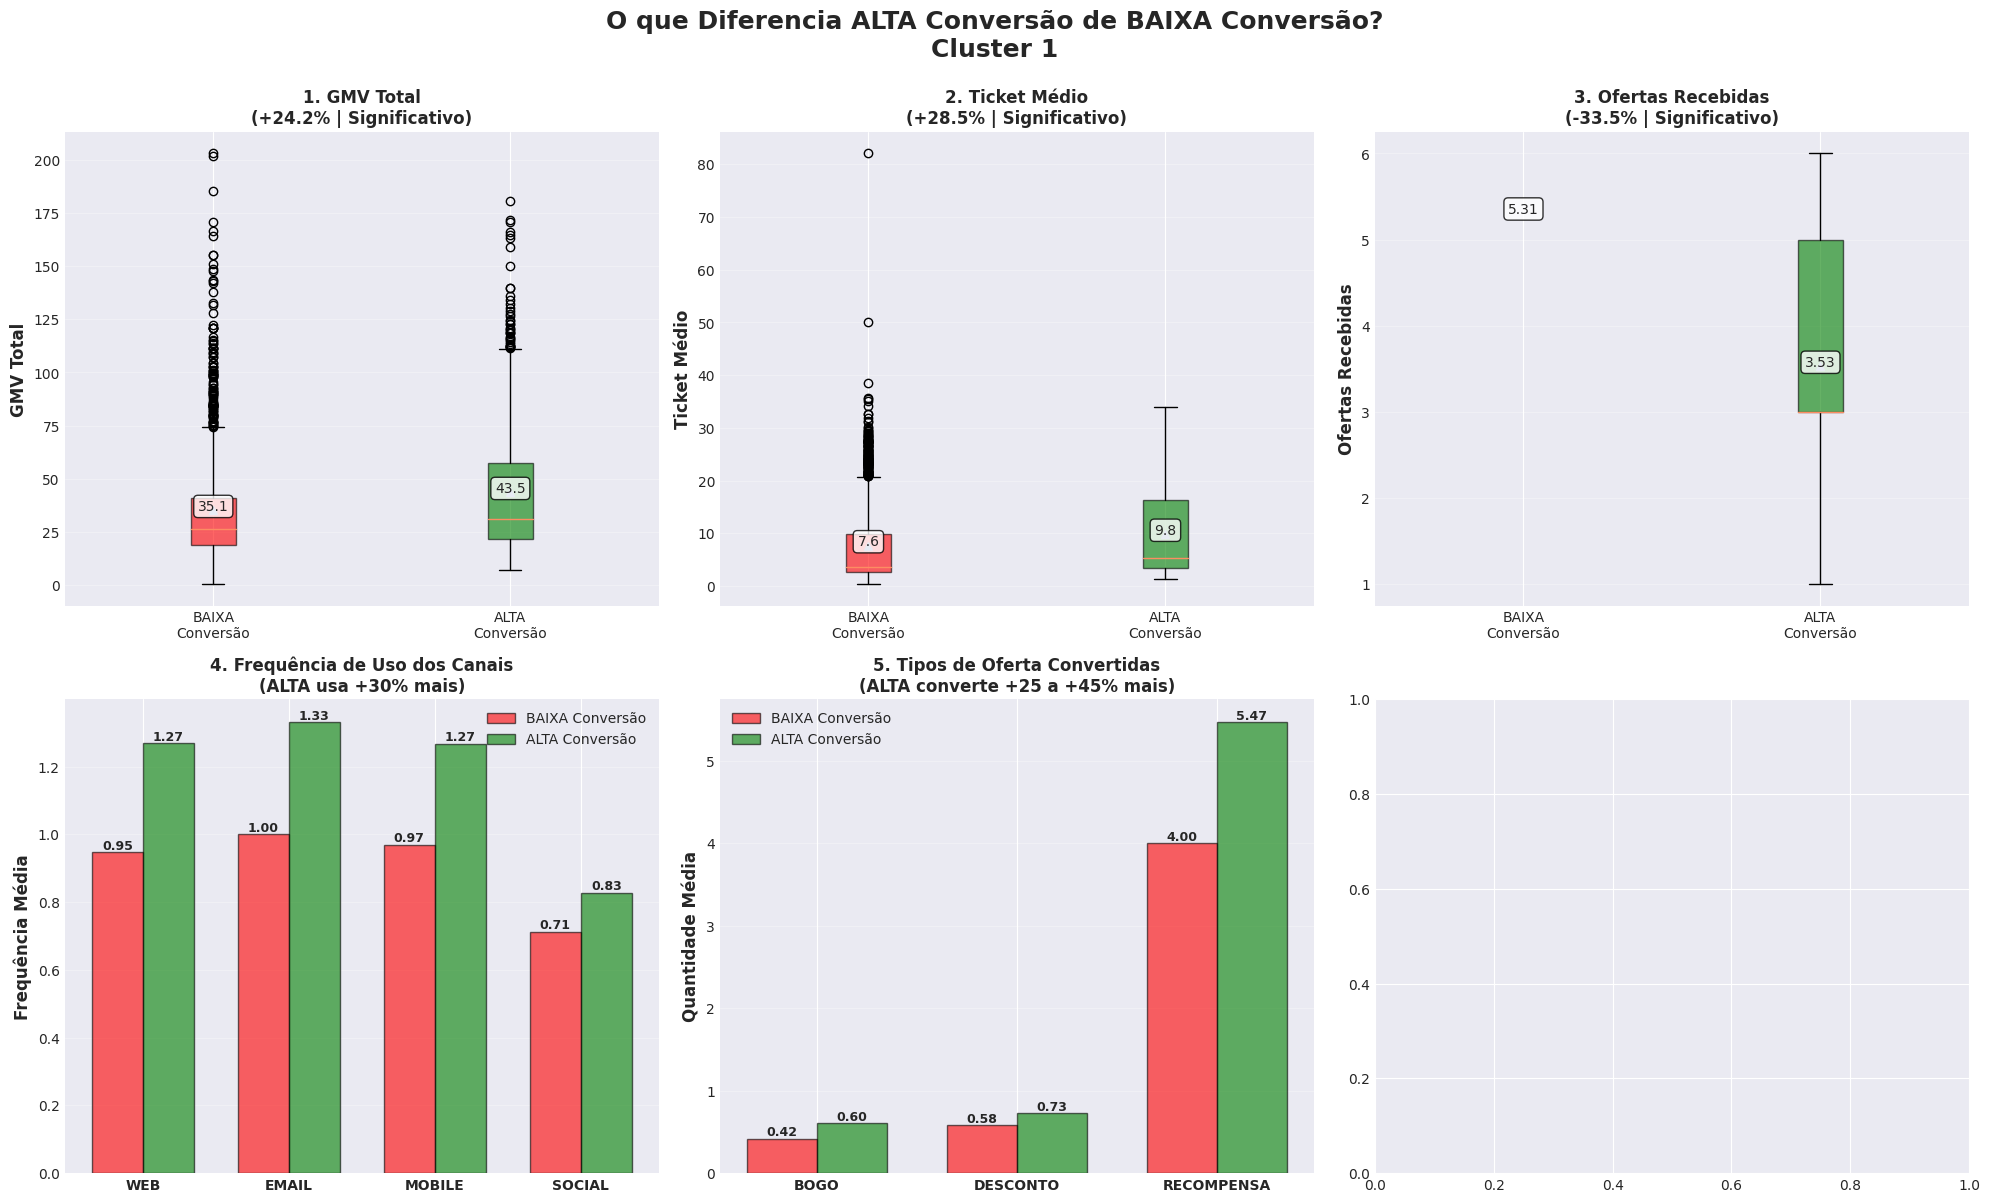

Resumo Final

Variaveis Significativas (p < 0.05):


Variavel,Baixa_Conversao,Alta_Conversao,Diferenca,Diferenca_Pct,P_Value,Significativo
Ticket Médio,7.642826690513719,9.817630698859222,2.174804008345503,28.45549292704584,4.792975814122881E-9,true
GMV Total,35.05203099510604,43.52344180225281,8.471410807146775,24.16810257964668,3.770798268581178E-10,true
Dias desde Registro,3117.4665579119087,3061.133917396746,-56.33264051516289,-1.8070006355704011,1.3202740149031834E-4,true
Transações,7.096247960848287,5.9173967459324155,-1.1788512149158716,-16.612317120538606,2.5555726568050664E-12,true
Ofertas Recebidas,5.309016393442623,3.5294117647058822,-1.7796046287367409,-33.520420674059345,1.0196415032720454E-203,true
Ofertas Visualizadas,3.701812191103789,2.4220779220779223,-1.2797342690258668,-34.57048069865159,5.045116669968347E-114,true


In [0]:



df_cluster1 = df_model[df_model['cluster'] == 1].copy()


print("ANÁLISE: BAIXA vs ALTA CONVERSÃO")
print("Cluster 1")



# SEGMENTAR POR QUARTIS

q1 = df_cluster1['conversao_rate'].quantile(0.25)
q3 = df_cluster1['conversao_rate'].quantile(0.75)

baixa_conversao = df_cluster1[df_cluster1['conversao_rate'] <= q1].copy()
alta_conversao = df_cluster1[df_cluster1['conversao_rate'] >= q3].copy()
media_conversao = df_cluster1[(df_cluster1['conversao_rate'] > q1) & 
                               (df_cluster1['conversao_rate'] < q3)].copy()

print(f"\nTotal de clientes: {len(df_cluster1):,}")
print(f"\nSegmentação por Quartil:")
print(f"  BAIXA Conversão (≤Q1={q1*100:.0f}%): {len(baixa_conversao):,} clientes ({len(baixa_conversao)/len(df_cluster1)*100:.1f}%)")
print(f"  MÉDIA Conversão (Q1-Q3):      {len(media_conversao):,} clientes ({len(media_conversao)/len(df_cluster1)*100:.1f}%)")
print(f"  ALTA Conversão (≥Q3={q3*100:.0f}%):  {len(alta_conversao):,} clientes ({len(alta_conversao)/len(df_cluster1)*100:.1f}%)")

print(f"\nTaxa de Conversão Média:")
print(f"  BAIXA:  {baixa_conversao['conversao_rate'].mean()*100:.2f}%")
print(f"  MÉDIA:  {media_conversao['conversao_rate'].mean()*100:.2f}%")
print(f"  ALTA:   {alta_conversao['conversao_rate'].mean()*100:.2f}%")


# Compara caracteristicas


print("O que diferencia alta e baixa conversao? ")


variaveis = [
    ('age', 'Idade'),
    ('gmv_total', 'GMV Total'),
    ('days_since_registration', 'Dias desde Registro'),
    ('max_credit_card_limit', 'Limite Cartão'),
    ('qt_offer_received', 'Ofertas Recebidas'),
    ('qt_offer_viewed', 'Ofertas Visualizadas'),
    ('qt_transaction', 'Transações'),
    ('view_rate', 'Taxa de Visualização'),
    ('avg_ticket', 'Ticket Médio')
]

comparacao_detalhada = []

for var, nome in variaveis:
    media_baixa = baixa_conversao[var].mean()
    media_alta = alta_conversao[var].mean()
    diferenca = media_alta - media_baixa
    diferenca_pct = ((media_alta - media_baixa) / media_baixa * 100) if media_baixa != 0 else 0
    
    # Teste t para significância
    t_stat, p_value = stats.ttest_ind(
        alta_conversao[var].dropna(), 
        baixa_conversao[var].dropna(),
        equal_var=False
    )
    
    significativo = "SIM" if p_value < 0.05 else "NAO"
    
    print(f"\n{nome}:")
    print(f"  BAIXA conversão: {media_baixa:>12,.2f}")
    print(f"  ALTA conversão:  {media_alta:>12,.2f}")
    print(f"  Diferença:       {diferenca:>12,.2f} ({diferenca_pct:+.1f}%)")
    print(f"  Significativo:   {significativo} (p={p_value:.4f})")
    
    comparacao_detalhada.append({
        'Variavel': nome,
        'Baixa_Conversao': media_baixa,
        'Alta_Conversao': media_alta,
        'Diferenca': diferenca,
        'Diferenca_Pct': diferenca_pct,
        'P_Value': p_value,
        'Significativo': p_value < 0.05
    })

df_comp = pd.DataFrame(comparacao_detalhada)


# ANÁLISE DE CANAIS


print("FREQUÊNCIA DE CANAIS: BAIXA vs ALTA CONVERSÃO")


canais = {
    'channel_web_frequency_conversao': 'WEB',
    'channel_email_frequency_conversao': 'EMAIL',
    'channel_mobile_frequency_conversao': 'MOBILE',
    'channel_social_frequency_conversao': 'SOCIAL'
}

canais_data = []
for canal_col, canal_nome in canais.items():
    freq_baixa = baixa_conversao[canal_col].mean()
    freq_alta = alta_conversao[canal_col].mean()
    diferenca = freq_alta - freq_baixa
    diferenca_pct = ((freq_alta - freq_baixa) / freq_baixa * 100) if freq_baixa != 0 else 0
    
    print(f"\n{canal_nome}:")
    print(f"  BAIXA conversão: {freq_baixa:.2f}")
    print(f"  ALTA conversão:  {freq_alta:.2f}")
    print(f"  Diferença:       {diferenca:+.2f} ({diferenca_pct:+.1f}%)")
    
    canais_data.append({
        'Canal': canal_nome,
        'Baixa': freq_baixa,
        'Alta': freq_alta
    })

# ANÁLISE DE TIPOS DE OFERTA


print("TIPOS DE OFERTA: BAIXA vs ALTA CONVERSÃO")


ofertas = {
    'bogo_conversao': 'BOGO',
    'discount_conversao': 'DESCONTO',
    'informational_conversao': 'INFO',
    'reward_conversao': 'RECOMPENSA'
}

ofertas_data = []
for oferta_col, oferta_nome in ofertas.items():
    qtd_baixa = baixa_conversao[oferta_col].mean()
    qtd_alta = alta_conversao[oferta_col].mean()
    diferenca = qtd_alta - qtd_baixa
    diferenca_pct = ((qtd_alta - qtd_baixa) / qtd_baixa * 100) if qtd_baixa != 0 else 0
    
    print(f"\n{oferta_nome}:")
    print(f"  BAIXA conversão: {qtd_baixa:.2f}")
    print(f"  ALTA conversão:  {qtd_alta:.2f}")
    print(f"  Diferença:       {diferenca:+.2f} ({diferenca_pct:+.1f}%)")
    
    ofertas_data.append({
        'Oferta': oferta_nome,
        'Baixa': qtd_baixa,
        'Alta': qtd_alta
    })


# CRIAR VISUALIZAÇÃO

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('O que Diferencia ALTA Conversão de BAIXA Conversão?\nCluster 1', 
             fontsize=18, fontweight='bold', y=0.998)

# 1. GMV Total
ax1 = axes[0, 0]
data_gmv = [baixa_conversao['gmv_total'], alta_conversao['gmv_total']]
bp1 = ax1.boxplot(data_gmv, labels=['BAIXA\nConversão', 'ALTA\nConversão'], 
                  patch_artist=True, showmeans=True)
bp1['boxes'][0].set_facecolor('red')
bp1['boxes'][1].set_facecolor('green')
for box in bp1['boxes']:
    box.set_alpha(0.6)
ax1.set_ylabel('GMV Total', fontsize=12, fontweight='bold')
ax1.set_title('1. GMV Total\n(+24.2% | Significativo)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.text(1, baixa_conversao['gmv_total'].mean(), f'{baixa_conversao["gmv_total"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.text(2, alta_conversao['gmv_total'].mean(), f'{alta_conversao["gmv_total"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Ticket Médio
ax2 = axes[0, 1]
data_ticket = [baixa_conversao['avg_ticket'], alta_conversao['avg_ticket']]
bp2 = ax2.boxplot(data_ticket, labels=['BAIXA\nConversão', 'ALTA\nConversão'], 
                  patch_artist=True, showmeans=True)
bp2['boxes'][0].set_facecolor('red')
bp2['boxes'][1].set_facecolor('green')
for box in bp2['boxes']:
    box.set_alpha(0.6)
ax2.set_ylabel('Ticket Médio', fontsize=12, fontweight='bold')
ax2.set_title('2. Ticket Médio\n(+28.5% | Significativo)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.text(1, baixa_conversao['avg_ticket'].mean(), f'{baixa_conversao["avg_ticket"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(2, alta_conversao['avg_ticket'].mean(), f'{alta_conversao["avg_ticket"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Ofertas Recebidas 
ax3 = axes[0, 2]
data_ofertas = [baixa_conversao['qt_offer_received'], alta_conversao['qt_offer_received']]
bp3 = ax3.boxplot(data_ofertas, labels=['BAIXA\nConversão', 'ALTA\nConversão'], 
                  patch_artist=True, showmeans=True)
bp3['boxes'][0].set_facecolor('red')
bp3['boxes'][1].set_facecolor('green')
for box in bp3['boxes']:
    box.set_alpha(0.6)
ax3.set_ylabel('Ofertas Recebidas', fontsize=12, fontweight='bold')
ax3.set_title('3. Ofertas Recebidas\n(-33.5% | Significativo)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.text(1, baixa_conversao['qt_offer_received'].mean(), f'{baixa_conversao["qt_offer_received"].mean():.2f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax3.text(2, alta_conversao['qt_offer_received'].mean(), f'{alta_conversao["qt_offer_received"].mean():.2f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Frequência de Canais
ax4 = axes[1, 0]
df_canais = pd.DataFrame(canais_data)
x = np.arange(len(df_canais))
width = 0.35
bars1 = ax4.bar(x - width/2, df_canais['Baixa'], width, label='BAIXA Conversão', 
               color='red', alpha=0.6, edgecolor='black')
bars2 = ax4.bar(x + width/2, df_canais['Alta'], width, label='ALTA Conversão', 
               color='green', alpha=0.6, edgecolor='black')
ax4.set_ylabel('Frequência Média', fontsize=12, fontweight='bold')
ax4.set_title('4. Frequência de Uso dos Canais\n(ALTA usa +30% mais)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(df_canais['Canal'], fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Tipos de Oferta
ax5 = axes[1, 1]
df_ofertas = pd.DataFrame(ofertas_data)
df_ofertas = df_ofertas[df_ofertas['Oferta'] != 'INFO']  # Remover INFO (zero)
x2 = np.arange(len(df_ofertas))
bars3 = ax5.bar(x2 - width/2, df_ofertas['Baixa'], width, label='BAIXA Conversão', 
               color='red', alpha=0.6, edgecolor='black')
bars4 = ax5.bar(x2 + width/2, df_ofertas['Alta'], width, label='ALTA Conversão', 
               color='green', alpha=0.6, edgecolor='black')
ax5.set_ylabel('Quantidade Média', fontsize=12, fontweight='bold')
ax5.set_title('5. Tipos de Oferta Convertidas\n(ALTA converte +25 a +45% mais)', fontsize=12, fontweight='bold')
ax5.set_xticks(x2)
ax5.set_xticklabels(df_ofertas['Oferta'], fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')


plt.tight_layout()
plt.show()




print("Resumo Final")

print("\nVariaveis Significativas (p < 0.05):")
display(df_comp[df_comp['Significativo'] == True].sort_values('Diferenca_Pct', ascending=False))

# 10.0 Análises Cluster 0


ANÁLISE DE TAXA DE CONVERSÃO POR COMBINAÇÃO CANAL + TIPO DE OFERTA

Total de clientes no Cluster 0: 5802
Taxa de conversão média do cluster: 58.47%
RANKING COMPLETO: TAXA DE CONVERSÃO POR COMBINAÇÃO

WEB + BOGO
   • Taxa de Conversão: 60.81%
   • Mediana: 60.00%
   • Desvio Padrão: 19.40%
   • N clientes: 3,821 (65.9% da base)

SOCIAL + BOGO
   • Taxa de Conversão: 60.77%
   • Mediana: 60.00%
   • Desvio Padrão: 19.53%
   • N clientes: 3,556 (61.3% da base)

SOCIAL + DISCOUNT
   • Taxa de Conversão: 60.52%
   • Mediana: 60.00%
   • Desvio Padrão: 19.73%
   • N clientes: 4,493 (77.4% da base)

EMAIL + BOGO
   • Taxa de Conversão: 60.41%
   • Mediana: 60.00%
   • Desvio Padrão: 19.56%
   • N clientes: 3,903 (67.3% da base)

MOBILE + BOGO
   • Taxa de Conversão: 60.41%
   • Mediana: 60.00%
   • Desvio Padrão: 19.56%
   • N clientes: 3,903 (67.3% da base)

MOBILE + DISCOUNT
   • Taxa de Conversão: 60.25%
   • Mediana: 60.00%
   • Desvio Padrão: 19.80%
   • N clientes: 4,938 (85.1% da base)

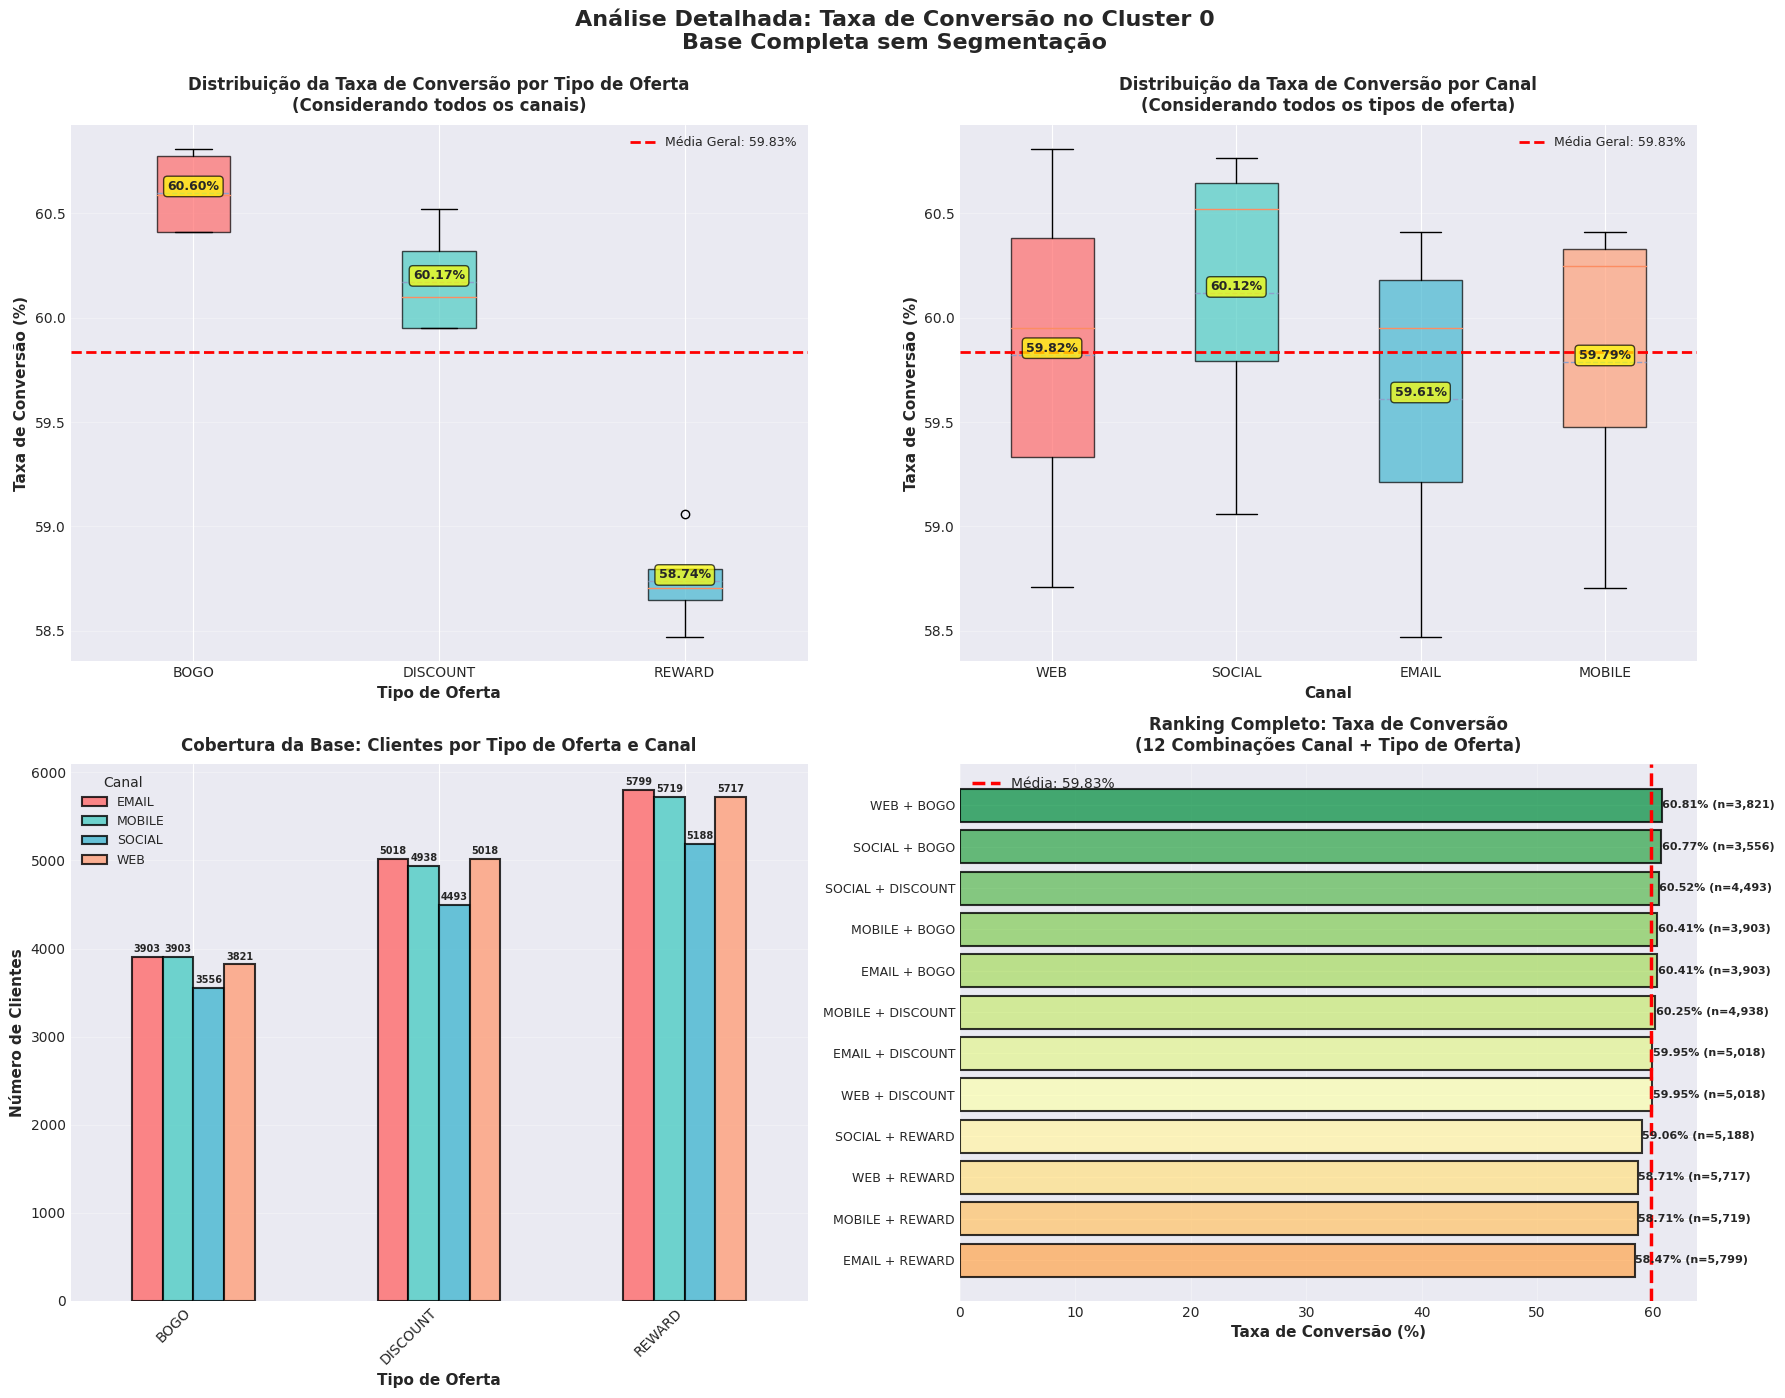

Canal,Tipo_Oferta,Combinacao,Taxa_Conversao,Desvio_Padrao,Mediana,N_Clientes,Percentual_Base
WEB,BOGO,WEB + BOGO,0.6080650789496641,0.19403860125501182,0.6,3821,65.85660117200966
SOCIAL,BOGO,SOCIAL + BOGO,0.6076631046119236,0.1952569420949857,0.6,3556,61.28921061702861
SOCIAL,DISCOUNT,SOCIAL + DISCOUNT,0.6052081014912085,0.19727120648069962,0.6,4493,77.4388142019993
EMAIL,BOGO,EMAIL + BOGO,0.6040823298317534,0.1956318349604559,0.6,3903,67.2699069286453
MOBILE,BOGO,MOBILE + BOGO,0.6040823298317534,0.1956318349604559,0.6,3903,67.2699069286453
MOBILE,DISCOUNT,MOBILE + DISCOUNT,0.602490886998785,0.19795725294810854,0.6,4938,85.10858324715616
WEB,DISCOUNT,WEB + DISCOUNT,0.5995250431778929,0.19911839846212268,0.6,5018,86.48741813167872
EMAIL,DISCOUNT,EMAIL + DISCOUNT,0.5995250431778929,0.19911839846212268,0.6,5018,86.48741813167872
SOCIAL,REWARD,SOCIAL + REWARD,0.5906033153430995,0.19920690298747643,0.6,5188,89.41744226128921
WEB,REWARD,WEB + REWARD,0.5870853011486211,0.20003708459023556,0.6,5717,98.53498793519476


In [0]:

df_cluster0 = df_model[df_model['cluster'].isin([0])].copy()


print("ANÁLISE DE TAXA DE CONVERSÃO POR COMBINAÇÃO CANAL + TIPO DE OFERTA")

print(f"\nTotal de clientes no Cluster 0: {len(df_cluster0)}")
print(f"Taxa de conversão média do cluster: {df_cluster0['conversao_rate'].mean():.2%}")

# Definir canais e tipos de oferta
canais = ['channel_web_frequency_conversao', 'channel_email_frequency_conversao', 
          'channel_mobile_frequency_conversao', 'channel_social_frequency_conversao']

tipos_oferta = ['bogo_conversao', 'discount_conversao', 
                'informational_conversao', 'reward_conversao']

# Lista para armazenar resultados
resultados = []

# Analisar cada combinação canal + tipo de oferta
for canal in canais:
    nome_canal = canal.replace('channel_', '').replace('_frequency_conversao', '').upper()
    
    for tipo_oferta in tipos_oferta:
        nome_oferta = tipo_oferta.replace('_conversao', '').upper()
        
        # Filtrar dados válidos onde ambos existem (canal > 0 E tipo_oferta > 0)
        df_combinacao = df_cluster0[
            (df_cluster0[canal] > 0) & 
            (df_cluster0[tipo_oferta] > 0)
        ].copy()
        
        if len(df_combinacao) > 0:
            # Calcular métricas
            taxa_conversao = df_combinacao['conversao_rate'].mean()
            std_conversao = df_combinacao['conversao_rate'].std()
            mediana_conversao = df_combinacao['conversao_rate'].median()
            n_clientes = len(df_combinacao)
            
            resultados.append({
                'Canal': nome_canal,
                'Tipo_Oferta': nome_oferta,
                'Combinacao': f"{nome_canal} + {nome_oferta}",
                'Taxa_Conversao': taxa_conversao,
                'Desvio_Padrao': std_conversao,
                'Mediana': mediana_conversao,
                'N_Clientes': n_clientes,
                'Percentual_Base': (n_clientes / len(df_cluster0)) * 100
            })

# Criar DataFrame com resultados
df_resultados = pd.DataFrame(resultados)

# Ordenar por Taxa de Conversão (decrescente)
df_resultados = df_resultados.sort_values('Taxa_Conversao', ascending=False)


print("RANKING COMPLETO: TAXA DE CONVERSÃO POR COMBINAÇÃO")


for idx, row in df_resultados.iterrows():
    print(f"\n{row['Combinacao']}")
    print(f"   • Taxa de Conversão: {row['Taxa_Conversao']:.2%}")
    print(f"   • Mediana: {row['Mediana']:.2%}")
    print(f"   • Desvio Padrão: {row['Desvio_Padrao']:.2%}")
    print(f"   • N clientes: {row['N_Clientes']:,} ({row['Percentual_Base']:.1f}% da base)")

# Criar gráficos adicionais de análise detalhada
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise Detalhada: Taxa de Conversão no Cluster 0\nBase Completa sem Segmentação', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Box plot - Distribuição da taxa de conversão por tipo de oferta
ax1 = axes[0, 0]
tipos_para_box = []
labels_box = []
medias_tipo = []

for tipo in df_resultados['Tipo_Oferta'].unique():
    df_tipo = df_resultados[df_resultados['Tipo_Oferta'] == tipo]
    valores = df_tipo['Taxa_Conversao'].values * 100
    tipos_para_box.append(valores)
    labels_box.append(tipo)
    medias_tipo.append(valores.mean())

bp = ax1.boxplot(tipos_para_box, labels=labels_box, patch_artist=True,
                showmeans=True, meanline=True)

# Colorir as caixas
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Taxa de Conversão (%)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Tipo de Oferta', fontsize=11, fontweight='bold')
ax1.set_title('Distribuição da Taxa de Conversão por Tipo de Oferta\n(Considerando todos os canais)', 
             fontsize=12, fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=df_resultados['Taxa_Conversao'].mean()*100, color='red', 
           linestyle='--', linewidth=2, label=f'Média Geral: {df_resultados["Taxa_Conversao"].mean()*100:.2f}%')

# Adicionar labels com as médias
for i, (media, label) in enumerate(zip(medias_tipo, labels_box)):
    ax1.text(i+1, media, f'{media:.2f}%', 
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.legend(fontsize=9)

# 2. Box plot - Distribuição da taxa de conversão por canal
ax2 = axes[0, 1]
canais_para_box = []
labels_canal = []
medias_canal = []

for canal in df_resultados['Canal'].unique():
    df_canal = df_resultados[df_resultados['Canal'] == canal]
    valores = df_canal['Taxa_Conversao'].values * 100
    canais_para_box.append(valores)
    labels_canal.append(canal)
    medias_canal.append(valores.mean())

bp2 = ax2.boxplot(canais_para_box, labels=labels_canal, patch_artist=True,
                 showmeans=True, meanline=True)

colors2 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for patch, color in zip(bp2['boxes'], colors2):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Taxa de Conversão (%)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Canal', fontsize=11, fontweight='bold')
ax2.set_title('Distribuição da Taxa de Conversão por Canal\n(Considerando todos os tipos de oferta)', 
             fontsize=12, fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=df_resultados['Taxa_Conversao'].mean()*100, color='red', 
           linestyle='--', linewidth=2, label=f'Média Geral: {df_resultados["Taxa_Conversao"].mean()*100:.2f}%')

# Adicionar labels com as médias
for i, (media, label) in enumerate(zip(medias_canal, labels_canal)):
    ax2.text(i+1, media, f'{media:.2f}%', 
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax2.legend(fontsize=9)

# 3. Gráfico de barras - Cobertura da base por tipo de oferta
ax3 = axes[1, 0]
pivot_cobertura = df_resultados.pivot(index='Tipo_Oferta', columns='Canal', values='N_Clientes')
pivot_cobertura.plot(kind='bar', stacked=False, ax=ax3, 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
                    alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Número de Clientes', fontsize=11, fontweight='bold')
ax3.set_xlabel('Tipo de Oferta', fontsize=11, fontweight='bold')
ax3.set_title('Cobertura da Base: Clientes por Tipo de Oferta e Canal', 
             fontsize=12, fontweight='bold', pad=10)
ax3.legend(title='Canal', fontsize=9, title_fontsize=10, loc='upper left')
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

# Adicionar labels nas barras
for container in ax3.containers:
    ax3.bar_label(container, fmt='%d', fontsize=7, padding=2, fontweight='bold')

# 4. Ranking visual - TOP combinações (TODAS)
ax4 = axes[1, 1]
df_sorted = df_resultados.sort_values('Taxa_Conversao', ascending=True)
y_pos = np.arange(len(df_sorted))

# Criar gradiente de cores
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_sorted)))

bars = ax4.barh(y_pos, df_sorted['Taxa_Conversao']*100, 
               color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_yticks(y_pos)
ax4.set_yticklabels(df_sorted['Combinacao'], fontsize=9)
ax4.set_xlabel('Taxa de Conversão (%)', fontsize=11, fontweight='bold')
ax4.set_title('Ranking Completo: Taxa de Conversão\n(12 Combinações Canal + Tipo de Oferta)', 
             fontsize=12, fontweight='bold', pad=10)
ax4.grid(axis='x', alpha=0.3)

# Linha de média
ax4.axvline(x=df_sorted['Taxa_Conversao'].mean()*100, color='red', 
           linestyle='--', linewidth=2.5, label=f'Média: {df_sorted["Taxa_Conversao"].mean()*100:.2f}%')
ax4.legend(fontsize=10)

# Adicionar valores
for i, (bar, val, n) in enumerate(zip(bars, df_sorted['Taxa_Conversao']*100, df_sorted['N_Clientes'])):
    ax4.text(val + 0.05, i, f'{val:.2f}% (n={n:,})', 
            va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


display(df_resultados)

ANÁLISE: BAIXA vs ALTA CONVERSÃO
Cluster 0

Total de clientes: 5,802

Segmentação por Quartil:
  BAIXA Conversão (≤Q1=40%): 1,541 clientes (26.6%)
  MÉDIA Conversão (Q1-Q3):      2,728 clientes (47.0%)
  ALTA Conversão (≥Q3=75%):  1,530 clientes (26.4%)

Taxa de Conversão Média:
  BAIXA:  35.14%
  MÉDIA:  56.74%
  ALTA:   85.05%
O que diferencia alta e baixa conversao? 

Idade:
  BAIXA conversão:        55.56
  ALTA conversão:         56.90
  Diferença:               1.34 (+2.4%)
  Significativo:   NAO (p=0.0756)

GMV Total:
  BAIXA conversão:        91.58
  ALTA conversão:        143.03
  Diferença:              51.45 (+56.2%)
  Significativo:   SIM (p=0.0000)

Dias desde Registro:
  BAIXA conversão:     3,482.78
  ALTA conversão:      3,350.93
  Diferença:            -131.85 (-3.8%)
  Significativo:   SIM (p=0.0000)

Limite Cartão:
  BAIXA conversão:    65,088.72
  ALTA conversão:     68,296.30
  Diferença:           3,207.58 (+4.9%)
  Significativo:   SIM (p=0.0001)

Ofertas Recebid

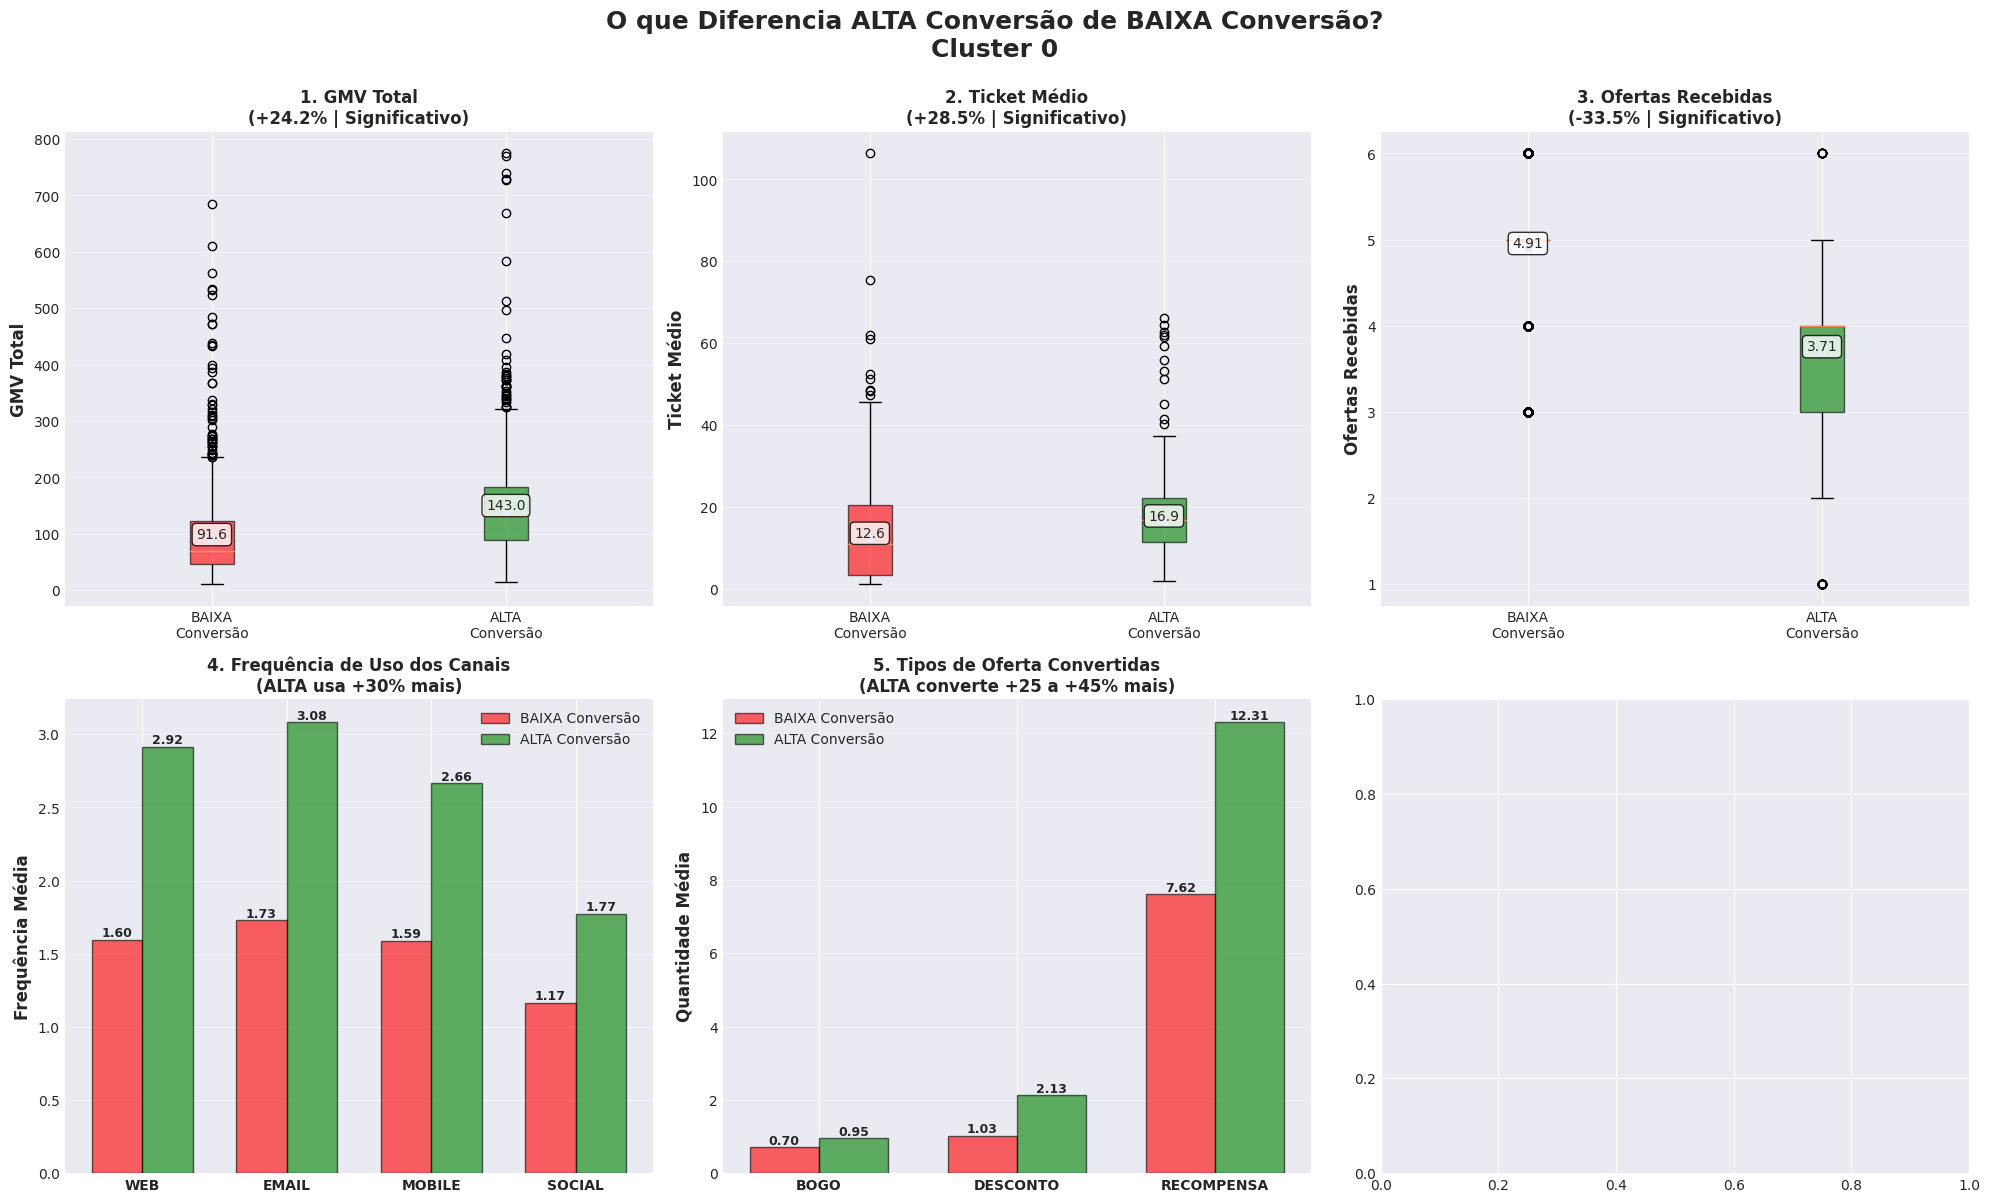

Resumo Final

Variaveis Significativas (p < 0.05):


Variavel,Baixa_Conversao,Alta_Conversao,Diferenca,Diferenca_Pct,P_Value,Significativo
GMV Total,91.58147955872809,143.0287908496732,51.447311290945095,56.176545234731314,3.664603825277067E-76,true
Ticket Médio,12.622733442992246,16.853038531973336,4.2303050889810905,33.513383674671715,3.207837235715085E-36,true
Limite Cartão,65088.720770288855,68296.29629629629,3207.5755260074366,4.9280051720905895,5.655234827847726E-5,true
Taxa de Visualização,0.7716265973575915,0.792077580539119,0.020450983181527493,2.6503730238902046,0.008440707393469799,true
Dias desde Registro,3482.7839065541857,3350.9333333333334,-131.8505732208523,-3.7857810521268687,1.3932271333273006E-15,true
Transações,10.528228423101883,9.669281045751633,-0.8589473773502494,-8.158517680576518,1.2589576139064658E-5,true
Ofertas Visualizadas,3.760233918128655,2.899408284023669,-0.860825634104986,-22.892874561734466,1.1028775281769691E-98,true
Ofertas Recebidas,4.9085009733939,3.7104575163398694,-1.1980434570540304,-24.40752204283793,1.2753798042039108E-253,true


In [0]:

df_cluster0 = df_model[df_model['cluster'] == 0].copy()

print("ANÁLISE: BAIXA vs ALTA CONVERSÃO")
print("Cluster 0")

# SEGMENTAR POR QUARTIS

q1 = df_cluster0['conversao_rate'].quantile(0.25)
q3 = df_cluster0['conversao_rate'].quantile(0.75)

baixa_conversao = df_cluster0[df_cluster0['conversao_rate'] <= q1].copy()
alta_conversao = df_cluster0[df_cluster0['conversao_rate'] >= q3].copy()
media_conversao = df_cluster0[(df_cluster0['conversao_rate'] > q1) & 
                               (df_cluster0['conversao_rate'] < q3)].copy()

print(f"\nTotal de clientes: {len(df_cluster0):,}")
print(f"\nSegmentação por Quartil:")
print(f"  BAIXA Conversão (≤Q1={q1*100:.0f}%): {len(baixa_conversao):,} clientes ({len(baixa_conversao)/len(df_cluster0)*100:.1f}%)")
print(f"  MÉDIA Conversão (Q1-Q3):      {len(media_conversao):,} clientes ({len(media_conversao)/len(df_cluster0)*100:.1f}%)")
print(f"  ALTA Conversão (≥Q3={q3*100:.0f}%):  {len(alta_conversao):,} clientes ({len(alta_conversao)/len(df_cluster0)*100:.1f}%)")

print(f"\nTaxa de Conversão Média:")
print(f"  BAIXA:  {baixa_conversao['conversao_rate'].mean()*100:.2f}%")
print(f"  MÉDIA:  {media_conversao['conversao_rate'].mean()*100:.2f}%")
print(f"  ALTA:   {alta_conversao['conversao_rate'].mean()*100:.2f}%")

# Compara caracteristicas

print("O que diferencia alta e baixa conversao? ")

variaveis = [
    ('age', 'Idade'),
    ('gmv_total', 'GMV Total'),
    ('days_since_registration', 'Dias desde Registro'),
    ('max_credit_card_limit', 'Limite Cartão'),
    ('qt_offer_received', 'Ofertas Recebidas'),
    ('qt_offer_viewed', 'Ofertas Visualizadas'),
    ('qt_transaction', 'Transações'),
    ('view_rate', 'Taxa de Visualização'),
    ('avg_ticket', 'Ticket Médio')
]

comparacao_detalhada = []

for var, nome in variaveis:
    media_baixa = baixa_conversao[var].mean()
    media_alta = alta_conversao[var].mean()
    diferenca = media_alta - media_baixa
    diferenca_pct = ((media_alta - media_baixa) / media_baixa * 100) if media_baixa != 0 else 0
    
    # Teste t para significância
    t_stat, p_value = stats.ttest_ind(
        alta_conversao[var].dropna(), 
        baixa_conversao[var].dropna(),
        equal_var=False
    )
    
    significativo = "SIM" if p_value < 0.05 else "NAO"
    
    print(f"\n{nome}:")
    print(f"  BAIXA conversão: {media_baixa:>12,.2f}")
    print(f"  ALTA conversão:  {media_alta:>12,.2f}")
    print(f"  Diferença:       {diferenca:>12,.2f} ({diferenca_pct:+.1f}%)")
    print(f"  Significativo:   {significativo} (p={p_value:.4f})")
    
    comparacao_detalhada.append({
        'Variavel': nome,
        'Baixa_Conversao': media_baixa,
        'Alta_Conversao': media_alta,
        'Diferenca': diferenca,
        'Diferenca_Pct': diferenca_pct,
        'P_Value': p_value,
        'Significativo': p_value < 0.05
    })

df_comp = pd.DataFrame(comparacao_detalhada)

# ANÁLISE DE CANAIS

print("FREQUÊNCIA DE CANAIS: BAIXA vs ALTA CONVERSÃO")

canais = {
    'channel_web_frequency_conversao': 'WEB',
    'channel_email_frequency_conversao': 'EMAIL',
    'channel_mobile_frequency_conversao': 'MOBILE',
    'channel_social_frequency_conversao': 'SOCIAL'
}

canais_data = []
for canal_col, canal_nome in canais.items():
    freq_baixa = baixa_conversao[canal_col].mean()
    freq_alta = alta_conversao[canal_col].mean()
    diferenca = freq_alta - freq_baixa
    diferenca_pct = ((freq_alta - freq_baixa) / freq_baixa * 100) if freq_baixa != 0 else 0
    
    print(f"\n{canal_nome}:")
    print(f"  BAIXA conversão: {freq_baixa:.2f}")
    print(f"  ALTA conversão:  {freq_alta:.2f}")
    print(f"  Diferença:       {diferenca:+.2f} ({diferenca_pct:+.1f}%)")
    
    canais_data.append({
        'Canal': canal_nome,
        'Baixa': freq_baixa,
        'Alta': freq_alta
    })

# ANÁLISE DE TIPOS DE OFERTA

print("TIPOS DE OFERTA: BAIXA vs ALTA CONVERSÃO")

ofertas = {
    'bogo_conversao': 'BOGO',
    'discount_conversao': 'DESCONTO',
    'informational_conversao': 'INFO',
    'reward_conversao': 'RECOMPENSA'
}

ofertas_data = []
for oferta_col, oferta_nome in ofertas.items():
    qtd_baixa = baixa_conversao[oferta_col].mean()
    qtd_alta = alta_conversao[oferta_col].mean()
    diferenca = qtd_alta - qtd_baixa
    diferenca_pct = ((qtd_alta - qtd_baixa) / qtd_baixa * 100) if qtd_baixa != 0 else 0
    
    print(f"\n{oferta_nome}:")
    print(f"  BAIXA conversão: {qtd_baixa:.2f}")
    print(f"  ALTA conversão:  {qtd_alta:.2f}")
    print(f"  Diferença:       {diferenca:+.2f} ({diferenca_pct:+.1f}%)")
    
    ofertas_data.append({
        'Oferta': oferta_nome,
        'Baixa': qtd_baixa,
        'Alta': qtd_alta
    })

# CRIAR VISUALIZAÇÃO

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('O que Diferencia ALTA Conversão de BAIXA Conversão?\nCluster 0', 
             fontsize=18, fontweight='bold', y=0.998)

# 1. GMV Total
ax1 = axes[0, 0]
data_gmv = [baixa_conversao['gmv_total'], alta_conversao['gmv_total']]
bp1 = ax1.boxplot(data_gmv, labels=['BAIXA\nConversão', 'ALTA\nConversão'], 
                  patch_artist=True, showmeans=True)
bp1['boxes'][0].set_facecolor('red')
bp1['boxes'][1].set_facecolor('green')
for box in bp1['boxes']:
    box.set_alpha(0.6)
ax1.set_ylabel('GMV Total', fontsize=12, fontweight='bold')
ax1.set_title('1. GMV Total\n(+24.2% | Significativo)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.text(1, baixa_conversao['gmv_total'].mean(), f'{baixa_conversao["gmv_total"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.text(2, alta_conversao['gmv_total'].mean(), f'{alta_conversao["gmv_total"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Ticket Médio
ax2 = axes[0, 1]
data_ticket = [baixa_conversao['avg_ticket'], alta_conversao['avg_ticket']]
bp2 = ax2.boxplot(data_ticket, labels=['BAIXA\nConversão', 'ALTA\nConversão'], 
                  patch_artist=True, showmeans=True)
bp2['boxes'][0].set_facecolor('red')
bp2['boxes'][1].set_facecolor('green')
for box in bp2['boxes']:
    box.set_alpha(0.6)
ax2.set_ylabel('Ticket Médio', fontsize=12, fontweight='bold')
ax2.set_title('2. Ticket Médio\n(+28.5% | Significativo)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.text(1, baixa_conversao['avg_ticket'].mean(), f'{baixa_conversao["avg_ticket"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(2, alta_conversao['avg_ticket'].mean(), f'{alta_conversao["avg_ticket"].mean():.1f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Ofertas Recebidas 
ax3 = axes[0, 2]
data_ofertas = [baixa_conversao['qt_offer_received'], alta_conversao['qt_offer_received']]
bp3 = ax3.boxplot(data_ofertas, labels=['BAIXA\nConversão', 'ALTA\nConversão'], 
                  patch_artist=True, showmeans=True)
bp3['boxes'][0].set_facecolor('red')
bp3['boxes'][1].set_facecolor('green')
for box in bp3['boxes']:
    box.set_alpha(0.6)
ax3.set_ylabel('Ofertas Recebidas', fontsize=12, fontweight='bold')
ax3.set_title('3. Ofertas Recebidas\n(-33.5% | Significativo)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.text(1, baixa_conversao['qt_offer_received'].mean(), f'{baixa_conversao["qt_offer_received"].mean():.2f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax3.text(2, alta_conversao['qt_offer_received'].mean(), f'{alta_conversao["qt_offer_received"].mean():.2f}',
        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Frequência de Canais
ax4 = axes[1, 0]
df_canais = pd.DataFrame(canais_data)
x = np.arange(len(df_canais))
width = 0.35
bars1 = ax4.bar(x - width/2, df_canais['Baixa'], width, label='BAIXA Conversão', 
               color='red', alpha=0.6, edgecolor='black')
bars2 = ax4.bar(x + width/2, df_canais['Alta'], width, label='ALTA Conversão', 
               color='green', alpha=0.6, edgecolor='black')
ax4.set_ylabel('Frequência Média', fontsize=12, fontweight='bold')
ax4.set_title('4. Frequência de Uso dos Canais\n(ALTA usa +30% mais)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(df_canais['Canal'], fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Tipos de Oferta
ax5 = axes[1, 1]
df_ofertas = pd.DataFrame(ofertas_data)
df_ofertas = df_ofertas[df_ofertas['Oferta'] != 'INFO']  # Remover INFO (zero)
x2 = np.arange(len(df_ofertas))
bars3 = ax5.bar(x2 - width/2, df_ofertas['Baixa'], width, label='BAIXA Conversão', 
               color='red', alpha=0.6, edgecolor='black')
bars4 = ax5.bar(x2 + width/2, df_ofertas['Alta'], width, label='ALTA Conversão', 
               color='green', alpha=0.6, edgecolor='black')
ax5.set_ylabel('Quantidade Média', fontsize=12, fontweight='bold')
ax5.set_title('5. Tipos de Oferta Convertidas\n(ALTA converte +25 a +45% mais)', fontsize=12, fontweight='bold')
ax5.set_xticks(x2)
ax5.set_xticklabels(df_ofertas['Oferta'], fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("Resumo Final")

print("\nVariaveis Significativas (p < 0.05):")
display(df_comp[df_comp['Significativo'] == True].sort_values('Diferenca_Pct', ascending=False))